<h1>Validation of Sea Surface Elevation Computation Method on the microSWIFT</h1>
Written By: EJ Rainville, Summer 2022

This notebook will validate the method for computing the sea surface elevation from the measurements of acceleration, rotation and heading from the microSWIFT. This validation will be a 3 step process including validation in deep water, validation in intermediate water and validation in shallow water. The microSWIFT measurements will be validated based on spectral and statistical parameters rather than the phase resolved time series. This is due to having free drifting buoys that do not stay next to verified, stationary instruments so we would need to make assumptions on how the phase of the waves would be shifted between the fixed instruments and the buoys. We therefore take care to use methods that should have the smallest amount of effect on phase as possible and assume that if the spectra and statistics align within statistical significance that these measurements are valid. We will also compare the computed horizontal velocites with the GPS velocites to valid that the phase was not affected in the computation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import pickle
import glob
import scipy.stats as st
%matplotlib widget

In [2]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.accel_nan_inds = accel_nans
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

In [3]:
from ahrs.filters import EKF
from scipy.spatial.transform import Rotation as R

def ekfCorrection(accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z):
    '''
    @edwinrainville

    Correct the body frame accelerations to the earth frame of reference through and extended Kalman Filter
    '''

    # Organize the acceleration data into arrays to be used in the ekf algorithm
    acc_data = np.array([accel_x-np.mean(accel_x), accel_y-np.mean(accel_y), accel_z-np.mean(accel_z)]).transpose()
    gyr_data = np.array([gyro_x-np.mean(gyro_x), gyro_y-np.mean(gyro_y), gyro_z-np.mean(gyro_z)]).transpose()
    mag_data = np.array([mag_x-np.mean(mag_x), mag_y-np.mean(mag_y), mag_z-np.mean(mag_z)]).transpose()

    # Rotate the acceleration data with extended Kalman filter
    # ** the variance of each sensor needs to be further examined
    # ** Variance is assumed from spec sheet
    # ekf = EKF(gyr=gyr_data, acc=acc_data, mag_data=mag_data, frequency=12, var_acc=0.000003, var_gyro=0.04, var_mag=.1, frame='NED')
    ekf = EKF(gyr=gyr_data, acc=acc_data, frequency=12, var_acc=0.000003, var_gyro=0.04, frame='NED')

    # Rotate the acclerations from the computed Quaterions
    r = R.from_quat(ekf.Q)
    accel_rotated = r.apply(acc_data)

    # Get acceleration data from the rotated structure
    accel_x_earth = accel_rotated[:,0]
    accel_y_earth = accel_rotated[:,1]
    accel_z_earth = accel_rotated[:,2]

    return accel_x_earth, accel_y_earth, accel_z_earth 

In [4]:
def computeEta(accel_z, fs, low_freq_cutoff, high_freq_cutoff, order):       
    # Define the filter
    b, a = signal.butter(order, [low_freq_cutoff, high_freq_cutoff], btype='bandpass', fs=fs)
    # b, a = signal.butter(order, low_freq_cutoff, btype='highpass', fs=fs)

    # Zero pad the edges to reduce edge effects
    pad_size = 500
    a_z_padded = np.zeros(accel_z.size + pad_size*2)
    a_z_padded[pad_size:-pad_size] = accel_z

    # Filter and integrate to velocity and position
    a_z = signal.filtfilt(b, a, a_z_padded)
    w_nofilt = integrate.cumulative_trapezoid(a_z, dx=1/fs, initial=0)
    w = signal.filtfilt(b, a, w_nofilt)
    z_nofilt = integrate.cumulative_trapezoid(w, dx=1/fs, initial=0)
    z = signal.filtfilt(b, a, z_nofilt)

    # Remove the edges of the time series due to the edge effects of filtering
    edge_removed = 100
    # t = t[edge_removed : -edge_removed]
    a_z = a_z[pad_size + edge_removed : -(pad_size + edge_removed)]
    w = w[pad_size + edge_removed : -(pad_size + edge_removed)]
    z = z[pad_size + edge_removed : -(pad_size + edge_removed)]

    return a_z, w, z

def computeSpectra(z, fs):
    nperseg = 3600
    overlap = 0.50
    f_raw, E_raw = signal.welch(z, fs=fs, window='hann', nperseg=nperseg, noverlap=np.floor(nperseg*overlap))

    # Band Average the Spectra
    points_to_average = 5
    num_sections = E_raw.size // points_to_average
    f_chunks = np.array_split(f_raw, num_sections)
    E_chunks = np.array_split(E_raw, num_sections)
    f = np.array([np.mean(chunk) for chunk in f_chunks ])
    E = np.array([np.mean(chunk) for chunk in E_chunks ])
    # dof = np.floor(2 * z.shape[0]//nperseg) * points_to_average
    dof = np.floor(points_to_average * (8/3) * (z.shape[0]/ (nperseg//2)))
    print('Degrees of Freedom: {}'.format(dof))
    return f, E, dof

def processZAccel(accel_z, fs, low_freq_cutoff, high_freq_cutoff, order):
    a_z, w, z = computeEta(accel_z, fs, low_freq_cutoff, high_freq_cutoff, order)

    # Compute the spectra
    f, E, dof = computeSpectra(z, fs)

    return a_z, w, z, f, E, dof

def computeBulkWaveParameters(f, E):
    # Compute Significant wave height 
    f_inds = np.where((f >= 0.04) & (f <= 0.5))[0]
    f_waves = np.array([f[i] for i in f_inds])
    E_waves = np.array([E[i] for i in f_inds])
    E_integrated = integrate.trapezoid(E_waves, f_waves)
    Hs = 4 * np.sqrt(E_integrated)
    
    # Compute Peak Period
    Tp = 1 / np.squeeze(f_waves[np.where(E_waves == np.amax(E_waves))])

    return Hs, Tp

In [5]:
def avgDistToAWAC(x, y, x_awac, y_awac):
    '''
    @edwinrainville

    Compute the distance from the 4.5 m AWAC to the average location of the microSWIFT
    '''
    # Compute average location of microSWIFT during track 
    x_avg = np.mean(x)
    y_avg = np.mean(y)

    # Compute Distance from AWAC to average location of microSWIFT
    dist = np.sqrt((x_avg - x_awac)**2 + (y_avg - y_awac)**2)

    return dist

<h2>Shallow Water Validation</h2>

In this section, the microSWIFT sea surface elevation computation method will be validated against an AWAC in nominally 4.5 meters depth. The data that we are using from the microSWIFTs is a subset of data from the main DUNEX experiment where each microSWIFT that was between 4-5 meters depth for at least 10 minutes continuously is compared to the spectra reported from the AWAC.

In [6]:
# Data from 4.5 meter AWAC
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))

# AWAC Confidence interval
from scipy.stats import chi2
probability = 0.95
alpha = 1 - probability

# AWAC confidence interval
DOF_awac = 48
c_awac = chi2.ppf([1 - alpha / 2, alpha / 2], DOF_awac)
c2_awac = DOF_awac / c_awac

# Filtering Characteristics
low_freq_cutoff = 0.05
high_freq_cutoff = 2
filt_order = 1
fs = 12.0

<h3>Mission 7 Validation</h3>

Degrees of Freedom: 173.0
Degrees of Freedom: 173.0
Degrees of Freedom: 173.0
Degrees of Freedom: 121.0
Degrees of Freedom: 173.0
Degrees of Freedom: 121.0


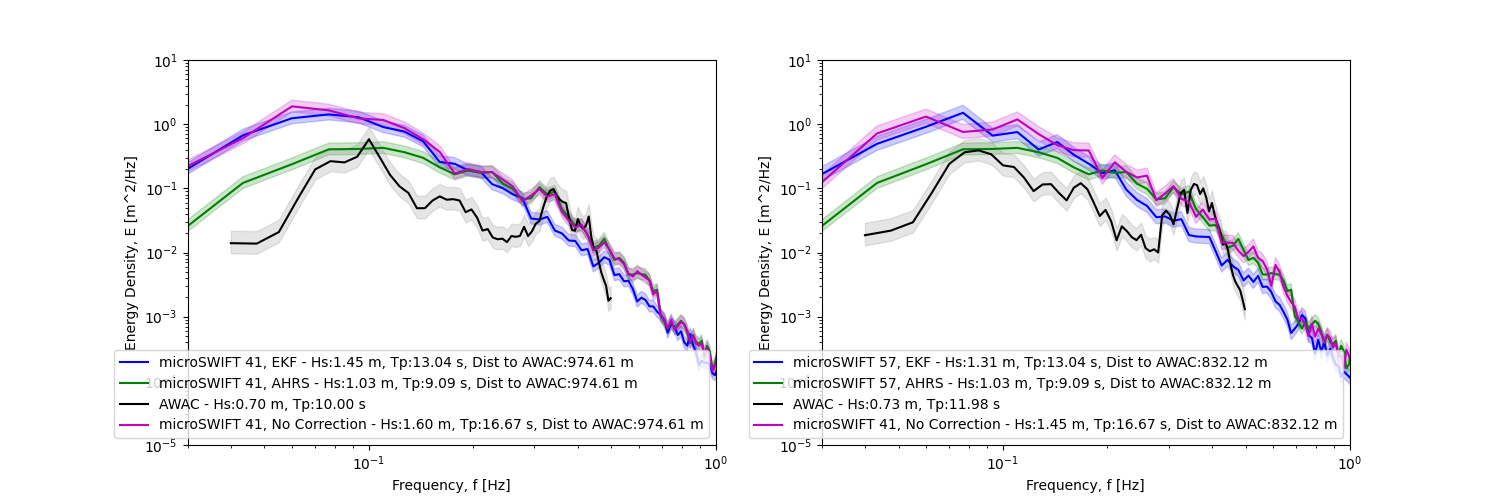

In [7]:
# mission 7, microSWIFT 41
# EKF
nearAWAC_mission7_microSWIFT41 = io.loadmat('./data/nearAWACData_mission_7_microSWIFT_41.mat')
mission7_microSWIFT41_accel_x, mission7_microSWIFT41_accel_y, mission7_microSWIFT41_accel_z =  ekfCorrection(nearAWAC_mission7_microSWIFT41['a_x'][0], nearAWAC_mission7_microSWIFT41['a_y'][0], nearAWAC_mission7_microSWIFT41['a_z'][0], nearAWAC_mission7_microSWIFT41['gyro_x'][0], nearAWAC_mission7_microSWIFT41['gyro_y'][0], nearAWAC_mission7_microSWIFT41['gyro_z'][0], nearAWAC_mission7_microSWIFT41['mag_x'][0], nearAWAC_mission7_microSWIFT41['mag_y'][0], nearAWAC_mission7_microSWIFT41['mag_z'][0])
mission7_microSWIFT41_accel_z_filt, mission7_microSWIFT41_w, mission7_microSWIFT41_z, mission7_microSWIFT41_f, mission7_microSWIFT41_E, mission7_microSWIFT41_dof = processZAccel(mission7_microSWIFT41_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT41 = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT41_dof)
c2_mission7_microSWIFT41 = mission7_microSWIFT41_dof / c_mission7_microSWIFT41
mission7_microSWIFT41_Hs, mission7_microSWIFT41_Tp = computeBulkWaveParameters(mission7_microSWIFT41_f, mission7_microSWIFT41_E)
mission7_microSWIFT41_dist2awac = avgDistToAWAC(nearAWAC_mission7_microSWIFT41['x'][0], nearAWAC_mission7_microSWIFT41['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission7_microSWIFT41_ahrs = io.loadmat('./data/ahrs_mission_7_microSWIFT_41.mat')
mission7_microSWIFT41_accel_z_filt_ahrs, mission7_microSWIFT41_w_ahrs, mission7_microSWIFT41_z_ahrs, mission7_microSWIFT41_f_ahrs, mission7_microSWIFT41_E_ahrs, mission7_microSWIFT41_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission7_microSWIFT41_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT41_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT41_dof_ahrs)
c2_mission7_microSWIFT41_ahrs = mission7_microSWIFT41_dof_ahrs / c_mission7_microSWIFT41_ahrs
mission7_microSWIFT41_Hs_ahrs, mission7_microSWIFT41_Tp_ahrs = computeBulkWaveParameters(mission7_microSWIFT41_f_ahrs, mission7_microSWIFT41_E_ahrs)
# No Correction 
mission7_microSWIFT41_nc_accel_z_filt, mission7_microSWIFT41_nc_w, mission7_microSWIFT41_nc_z, mission7_microSWIFT41_nc_f, mission7_microSWIFT41_nc_E, mission7_microSWIFT41_nc_dof = processZAccel(nearAWAC_mission7_microSWIFT41['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT41_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT41_nc_dof)
c2_mission7_microSWIFT41_nc = mission7_microSWIFT41_nc_dof / c_mission7_microSWIFT41_nc
mission7_microSWIFT41_nc_Hs, mission7_microSWIFT41_nc_Tp = computeBulkWaveParameters(mission7_microSWIFT41_nc_f, mission7_microSWIFT41_nc_E)


# mission 7, microSWIFT 57
# EKF
nearAWAC_mission7_microSWIFT57 = io.loadmat('./data/nearAWACData_mission_7_microSWIFT_57.mat')
mission7_microSWIFT57_accel_x, mission7_microSWIFT57_accel_y, mission7_microSWIFT57_accel_z =  ekfCorrection(nearAWAC_mission7_microSWIFT57['a_x'][0], nearAWAC_mission7_microSWIFT57['a_y'][0], nearAWAC_mission7_microSWIFT57['a_z'][0], nearAWAC_mission7_microSWIFT57['gyro_x'][0], nearAWAC_mission7_microSWIFT57['gyro_y'][0], nearAWAC_mission7_microSWIFT57['gyro_z'][0], nearAWAC_mission7_microSWIFT57['mag_x'][0], nearAWAC_mission7_microSWIFT57['mag_y'][0], nearAWAC_mission7_microSWIFT57['mag_z'][0])
mission7_microSWIFT57_accel_z_filt, mission7_microSWIFT57_w, mission7_microSWIFT57_z, mission7_microSWIFT57_f, mission7_microSWIFT57_E, mission7_microSWIFT57_dof = processZAccel(mission7_microSWIFT57_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT57 = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT57_dof)
c2_mission7_microSWIFT57 = mission7_microSWIFT57_dof / c_mission7_microSWIFT57
mission7_microSWIFT57_Hs, mission7_microSWIFT57_Tp = computeBulkWaveParameters(mission7_microSWIFT57_f, mission7_microSWIFT57_E)
mission7_microSWIFT57_dist2awac = avgDistToAWAC(nearAWAC_mission7_microSWIFT57['x'][0], nearAWAC_mission7_microSWIFT57['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission7_microSWIFT57_ahrs = io.loadmat('./data/ahrs_mission_7_microSWIFT_41.mat')
mission7_microSWIFT57_accel_z_filt_ahrs, mission7_microSWIFT57_w_ahrs, mission7_microSWIFT57_z_ahrs, mission7_microSWIFT57_f_ahrs, mission7_microSWIFT57_E_ahrs, mission7_microSWIFT57_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission7_microSWIFT57_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT57_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT57_dof_ahrs)
c2_mission7_microSWIFT57_ahrs = mission7_microSWIFT57_dof_ahrs / c_mission7_microSWIFT57_ahrs
mission7_microSWIFT57_Hs_ahrs, mission7_microSWIFT57_Tp_ahrs = computeBulkWaveParameters(mission7_microSWIFT57_f_ahrs, mission7_microSWIFT57_E_ahrs)
# No Correction 
mission7_microSWIFT57_nc_accel_z_filt, mission7_microSWIFT57_nc_w, mission7_microSWIFT57_nc_z, mission7_microSWIFT57_nc_f, mission7_microSWIFT57_nc_E, mission7_microSWIFT57_nc_dof = processZAccel(nearAWAC_mission7_microSWIFT57['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission7_microSWIFT57_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission7_microSWIFT57_nc_dof)
c2_mission7_microSWIFT57_nc = mission7_microSWIFT57_nc_dof / c_mission7_microSWIFT57_nc
mission7_microSWIFT57_nc_Hs, mission7_microSWIFT57_nc_Tp = computeBulkWaveParameters(mission7_microSWIFT57_nc_f, mission7_microSWIFT57_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission7, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

# microSWIFT 41
ax1.loglog(mission7_microSWIFT41_f, mission7_microSWIFT41_E, color='b', label='microSWIFT 41, EKF - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT41_Hs, mission7_microSWIFT41_Tp, mission7_microSWIFT41_dist2awac))
ax1.fill_between(mission7_microSWIFT41_f, mission7_microSWIFT41_E*c2_mission7_microSWIFT41[0], mission7_microSWIFT41_E*c2_mission7_microSWIFT41[1], color='b', alpha=.2)
ax1.loglog(mission7_microSWIFT41_f_ahrs, mission7_microSWIFT41_E_ahrs, color='g', label='microSWIFT 41, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT41_Hs_ahrs, mission7_microSWIFT41_Tp_ahrs, mission7_microSWIFT41_dist2awac))
ax1.fill_between(mission7_microSWIFT41_f_ahrs, mission7_microSWIFT41_E_ahrs*c2_mission7_microSWIFT41_ahrs[0], mission7_microSWIFT41_E_ahrs*c2_mission7_microSWIFT41_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission7_microSWIFT41['f_awac'][0], nearAWAC_mission7_microSWIFT41['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0], nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission7_microSWIFT41['f_awac'][0], nearAWAC_mission7_microSWIFT41['E_awac'][0]*c2_awac[0], nearAWAC_mission7_microSWIFT41['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.loglog(mission7_microSWIFT41_nc_f, mission7_microSWIFT41_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT41_nc_Hs, mission7_microSWIFT41_nc_Tp, mission7_microSWIFT41_dist2awac))
ax1.fill_between(mission7_microSWIFT41_nc_f, mission7_microSWIFT41_nc_E*c2_mission7_microSWIFT41_nc[0], mission7_microSWIFT41_nc_E*c2_mission7_microSWIFT41_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

# microSWIFT 57
ax2.loglog(mission7_microSWIFT57_f, mission7_microSWIFT57_E, color='b', label='microSWIFT 57, EKF - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT57_Hs, mission7_microSWIFT57_Tp, mission7_microSWIFT57_dist2awac))
ax2.fill_between(mission7_microSWIFT57_f, mission7_microSWIFT57_E*c2_mission7_microSWIFT57[0], mission7_microSWIFT57_E*c2_mission7_microSWIFT57[1], color='b', alpha=.2)
ax2.loglog(mission7_microSWIFT57_f_ahrs, mission7_microSWIFT57_E_ahrs, color='g', label='microSWIFT 57, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT57_Hs_ahrs, mission7_microSWIFT57_Tp_ahrs, mission7_microSWIFT57_dist2awac))
ax2.fill_between(mission7_microSWIFT57_f_ahrs, mission7_microSWIFT57_E_ahrs*c2_mission7_microSWIFT57_ahrs[0], mission7_microSWIFT57_E_ahrs*c2_mission7_microSWIFT57_ahrs[1], color='g', alpha=.2)
ax2.loglog(nearAWAC_mission7_microSWIFT57['f_awac'][0], nearAWAC_mission7_microSWIFT57['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0], nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0]))
ax2.fill_between(nearAWAC_mission7_microSWIFT57['f_awac'][0], nearAWAC_mission7_microSWIFT57['E_awac'][0]*c2_awac[0], nearAWAC_mission7_microSWIFT57['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax2.loglog(mission7_microSWIFT57_nc_f, mission7_microSWIFT57_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission7_microSWIFT57_nc_Hs, mission7_microSWIFT57_nc_Tp, mission7_microSWIFT57_dist2awac))
ax2.fill_between(mission7_microSWIFT57_nc_f, mission7_microSWIFT57_nc_E*c2_mission7_microSWIFT57_nc[0], mission7_microSWIFT57_nc_E*c2_mission7_microSWIFT57_nc[1], color='m', alpha=.2)
ax2.set_xlabel('Frequency, f [Hz]')
ax2.set_ylabel('Energy Density, E [m^2/Hz]')
ax2.legend()
ax2.set_xlim(0.03, 1)
ax2.set_ylim(10**-5, 10)

fig_mission7.savefig('./figures/mission7_validation.png')

<h3>Mission 18 Validation</h3>

Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 54.0
Degrees of Freedom: 54.0
Degrees of Freedom: 54.0
Degrees of Freedom: 57.0
Degrees of Freedom: 57.0
Degrees of Freedom: 57.0
Degrees of Freedom: 54.0
Degrees of Freedom: 54.0
Degrees of Freedom: 54.0


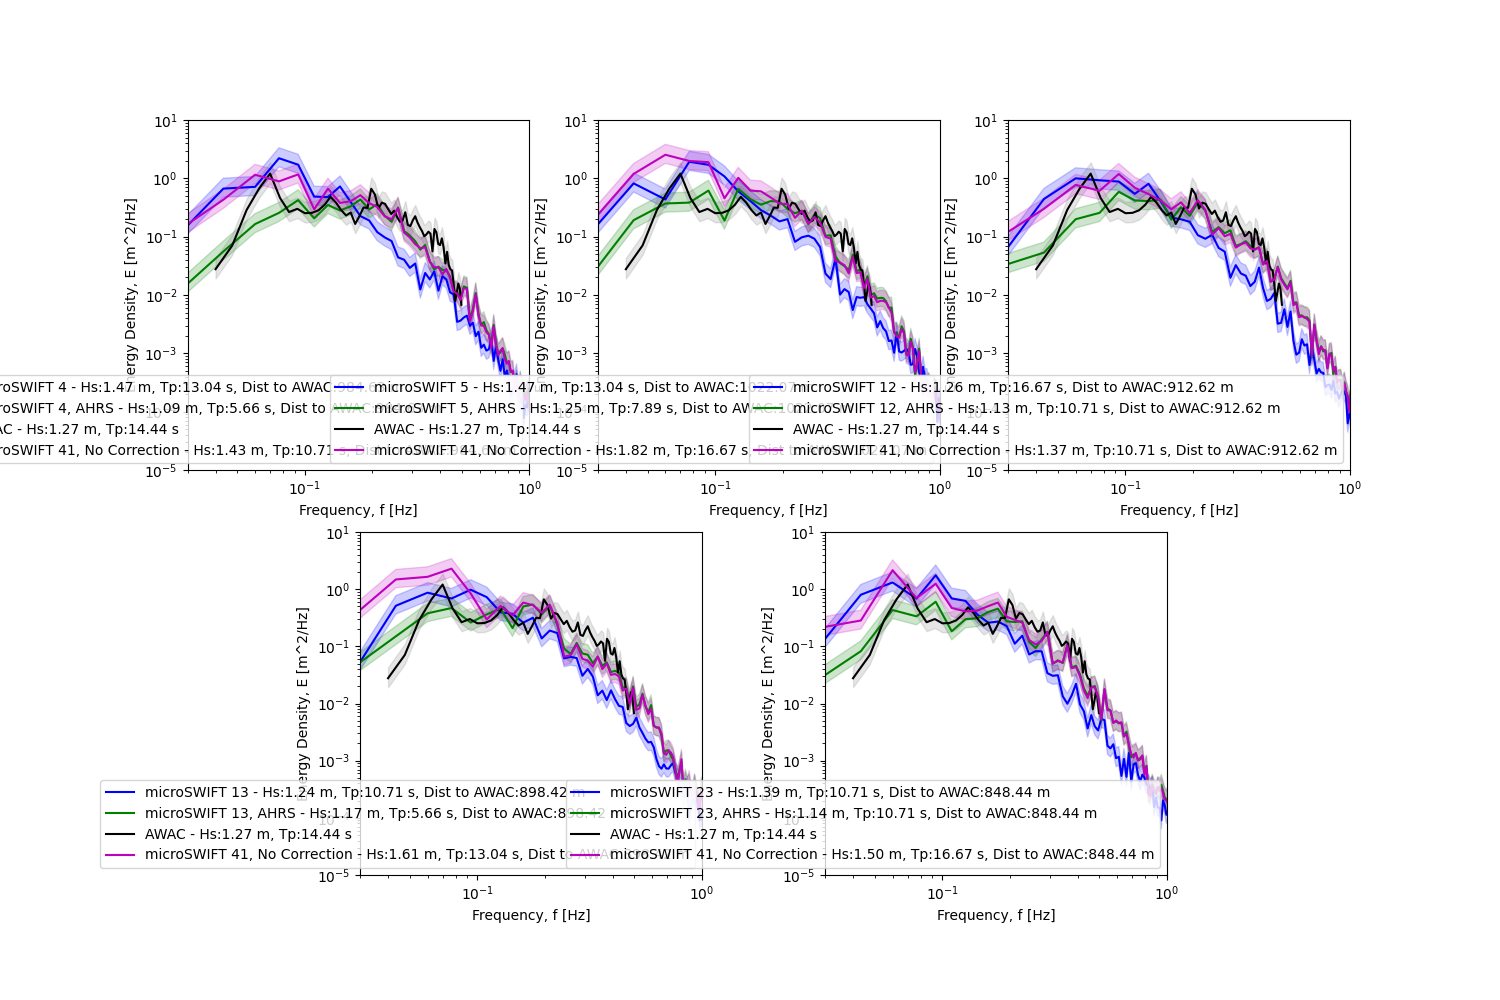

In [8]:
# mission 18, microSWIFT 4
# EKF
nearAWAC_mission18_microSWIFT4 = io.loadmat('./data/nearAWACData_mission18_microSWIFT_4.mat')
mission18_microSWIFT4_accel_x, mission18_microSWIFT4_accel_y, mission18_microSWIFT4_accel_z =  ekfCorrection(nearAWAC_mission18_microSWIFT4['a_x'][0], nearAWAC_mission18_microSWIFT4['a_y'][0], nearAWAC_mission18_microSWIFT4['a_z'][0], nearAWAC_mission18_microSWIFT4['gyro_x'][0], nearAWAC_mission18_microSWIFT4['gyro_y'][0], nearAWAC_mission18_microSWIFT4['gyro_z'][0], nearAWAC_mission18_microSWIFT4['mag_x'][0], nearAWAC_mission18_microSWIFT4['mag_y'][0], nearAWAC_mission18_microSWIFT4['mag_z'][0])
mission18_microSWIFT4_accel_z_filt, mission18_microSWIFT4_w, mission18_microSWIFT4_z, mission18_microSWIFT4_f, mission18_microSWIFT4_E, mission18_microSWIFT4_dof = processZAccel(mission18_microSWIFT4_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT4 = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT4_dof)
c2_mission18_microSWIFT4 = mission18_microSWIFT4_dof / c_mission18_microSWIFT4
mission18_microSWIFT4_Hs, mission18_microSWIFT4_Tp = computeBulkWaveParameters(mission18_microSWIFT4_f, mission18_microSWIFT4_E)
mission18_microSWIFT4_dist2awac = avgDistToAWAC(nearAWAC_mission18_microSWIFT4['x'][0], nearAWAC_mission18_microSWIFT4['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission18_microSWIFT4_ahrs = io.loadmat('./data/ahrs_mission18_microSWIFT_4.mat')
mission18_microSWIFT4_accel_z_filt_ahrs, mission18_microSWIFT4_w_ahrs, mission18_microSWIFT4_z_ahrs, mission18_microSWIFT4_f_ahrs, mission18_microSWIFT4_E_ahrs, mission18_microSWIFT4_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission18_microSWIFT4_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT4_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT4_dof_ahrs)
c2_mission18_microSWIFT4_ahrs = mission18_microSWIFT4_dof_ahrs / c_mission18_microSWIFT4_ahrs
mission18_microSWIFT4_Hs_ahrs, mission18_microSWIFT4_Tp_ahrs = computeBulkWaveParameters(mission18_microSWIFT4_f_ahrs, mission18_microSWIFT4_E_ahrs)
# No Correction 
mission18_microSWIFT4_nc_accel_z_filt, mission18_microSWIFT4_nc_w, mission18_microSWIFT4_nc_z, mission18_microSWIFT4_nc_f, mission18_microSWIFT4_nc_E, mission18_microSWIFT4_nc_dof = processZAccel(nearAWAC_mission18_microSWIFT4['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT4_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT4_nc_dof)
c2_mission18_microSWIFT4_nc = mission18_microSWIFT4_nc_dof / c_mission18_microSWIFT4_nc
mission18_microSWIFT4_nc_Hs, mission18_microSWIFT4_nc_Tp = computeBulkWaveParameters(mission18_microSWIFT4_nc_f, mission18_microSWIFT4_nc_E)

# mission 18, microSWIFT 5
# EKF
nearAWAC_mission18_microSWIFT5 = io.loadmat('./data/nearAWACData_mission18_microSWIFT_5.mat')
mission18_microSWIFT5_accel_x, mission18_microSWIFT5_accel_y, mission18_microSWIFT5_accel_z =  ekfCorrection(nearAWAC_mission18_microSWIFT5['a_x'][0], nearAWAC_mission18_microSWIFT5['a_y'][0], nearAWAC_mission18_microSWIFT5['a_z'][0], nearAWAC_mission18_microSWIFT5['gyro_x'][0], nearAWAC_mission18_microSWIFT5['gyro_y'][0], nearAWAC_mission18_microSWIFT5['gyro_z'][0], nearAWAC_mission18_microSWIFT5['mag_x'][0], nearAWAC_mission18_microSWIFT5['mag_y'][0], nearAWAC_mission18_microSWIFT5['mag_z'][0])
mission18_microSWIFT5_accel_z_filt, mission18_microSWIFT5_w, mission18_microSWIFT5_z, mission18_microSWIFT5_f, mission18_microSWIFT5_E, mission18_microSWIFT5_dof = processZAccel(mission18_microSWIFT5_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT5 = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT5_dof)
c2_mission18_microSWIFT5 = mission18_microSWIFT5_dof / c_mission18_microSWIFT5
mission18_microSWIFT5_Hs, mission18_microSWIFT5_Tp = computeBulkWaveParameters(mission18_microSWIFT5_f, mission18_microSWIFT5_E)
mission18_microSWIFT5_dist2awac = avgDistToAWAC(nearAWAC_mission18_microSWIFT5['x'][0], nearAWAC_mission18_microSWIFT5['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission18_microSWIFT5_ahrs = io.loadmat('./data/ahrs_mission18_microSWIFT_5.mat')
mission18_microSWIFT5_accel_z_filt_ahrs, mission18_microSWIFT5_w_ahrs, mission18_microSWIFT5_z_ahrs, mission18_microSWIFT5_f_ahrs, mission18_microSWIFT5_E_ahrs, mission18_microSWIFT5_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission18_microSWIFT5_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT5_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT5_dof_ahrs)
c2_mission18_microSWIFT5_ahrs = mission18_microSWIFT5_dof_ahrs / c_mission18_microSWIFT5_ahrs
mission18_microSWIFT5_Hs_ahrs, mission18_microSWIFT5_Tp_ahrs = computeBulkWaveParameters(mission18_microSWIFT5_f_ahrs, mission18_microSWIFT5_E_ahrs)
# No Correction 
mission18_microSWIFT5_nc_accel_z_filt, mission18_microSWIFT5_nc_w, mission18_microSWIFT5_nc_z, mission18_microSWIFT5_nc_f, mission18_microSWIFT5_nc_E, mission18_microSWIFT5_nc_dof = processZAccel(nearAWAC_mission18_microSWIFT5['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT5_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT5_nc_dof)
c2_mission18_microSWIFT5_nc = mission18_microSWIFT5_nc_dof / c_mission18_microSWIFT5_nc
mission18_microSWIFT5_nc_Hs, mission18_microSWIFT5_nc_Tp = computeBulkWaveParameters(mission18_microSWIFT5_nc_f, mission18_microSWIFT5_nc_E)

# mission 18, microSWIFT 12
# EKF
nearAWAC_mission18_microSWIFT12 = io.loadmat('./data/nearAWACData_mission18_microSWIFT_12.mat')
mission18_microSWIFT12_accel_x, mission18_microSWIFT12_accel_y, mission18_microSWIFT12_accel_z =  ekfCorrection(nearAWAC_mission18_microSWIFT12['a_x'][0], nearAWAC_mission18_microSWIFT12['a_y'][0], nearAWAC_mission18_microSWIFT12['a_z'][0], nearAWAC_mission18_microSWIFT12['gyro_x'][0], nearAWAC_mission18_microSWIFT12['gyro_y'][0], nearAWAC_mission18_microSWIFT12['gyro_z'][0], nearAWAC_mission18_microSWIFT12['mag_x'][0], nearAWAC_mission18_microSWIFT12['mag_y'][0], nearAWAC_mission18_microSWIFT12['mag_z'][0])
mission18_microSWIFT12_accel_z_filt, mission18_microSWIFT12_w, mission18_microSWIFT12_z, mission18_microSWIFT12_f, mission18_microSWIFT12_E, mission18_microSWIFT12_dof = processZAccel(mission18_microSWIFT12_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT12 = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT12_dof)
c2_mission18_microSWIFT12 = mission18_microSWIFT12_dof / c_mission18_microSWIFT12
mission18_microSWIFT12_Hs, mission18_microSWIFT12_Tp = computeBulkWaveParameters(mission18_microSWIFT12_f, mission18_microSWIFT12_E)
mission18_microSWIFT12_dist2awac = avgDistToAWAC(nearAWAC_mission18_microSWIFT12['x'][0], nearAWAC_mission18_microSWIFT12['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission18_microSWIFT12_ahrs = io.loadmat('./data/ahrs_mission18_microSWIFT_12.mat')
mission18_microSWIFT12_accel_z_filt_ahrs, mission18_microSWIFT12_w_ahrs, mission18_microSWIFT12_z_ahrs, mission18_microSWIFT12_f_ahrs, mission18_microSWIFT12_E_ahrs, mission18_microSWIFT12_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission18_microSWIFT12_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT12_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT12_dof_ahrs)
c2_mission18_microSWIFT12_ahrs = mission18_microSWIFT12_dof_ahrs / c_mission18_microSWIFT12_ahrs
mission18_microSWIFT12_Hs_ahrs, mission18_microSWIFT12_Tp_ahrs = computeBulkWaveParameters(mission18_microSWIFT12_f_ahrs, mission18_microSWIFT12_E_ahrs)
# No Correction 
mission18_microSWIFT12_nc_accel_z_filt, mission18_microSWIFT12_nc_w, mission18_microSWIFT12_nc_z, mission18_microSWIFT12_nc_f, mission18_microSWIFT12_nc_E, mission18_microSWIFT12_nc_dof = processZAccel(nearAWAC_mission18_microSWIFT12['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT12_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT12_nc_dof)
c2_mission18_microSWIFT12_nc = mission18_microSWIFT12_nc_dof / c_mission18_microSWIFT12_nc
mission18_microSWIFT12_nc_Hs, mission18_microSWIFT12_nc_Tp = computeBulkWaveParameters(mission18_microSWIFT12_nc_f, mission18_microSWIFT12_nc_E)

# mission 18, microSWIFT 13
# EKF
nearAWAC_mission18_microSWIFT13 = io.loadmat('./data/nearAWACData_mission18_microSWIFT_13.mat')
mission18_microSWIFT13_accel_x, mission18_microSWIFT13_accel_y, mission18_microSWIFT13_accel_z =  ekfCorrection(nearAWAC_mission18_microSWIFT13['a_x'][0], nearAWAC_mission18_microSWIFT13['a_y'][0], nearAWAC_mission18_microSWIFT13['a_z'][0], nearAWAC_mission18_microSWIFT13['gyro_x'][0], nearAWAC_mission18_microSWIFT13['gyro_y'][0], nearAWAC_mission18_microSWIFT13['gyro_z'][0], nearAWAC_mission18_microSWIFT13['mag_x'][0], nearAWAC_mission18_microSWIFT13['mag_y'][0], nearAWAC_mission18_microSWIFT13['mag_z'][0])
mission18_microSWIFT13_accel_z_filt, mission18_microSWIFT13_w, mission18_microSWIFT13_z, mission18_microSWIFT13_f, mission18_microSWIFT13_E, mission18_microSWIFT13_dof = processZAccel(mission18_microSWIFT13_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT13 = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT13_dof)
c2_mission18_microSWIFT13 = mission18_microSWIFT13_dof / c_mission18_microSWIFT13
mission18_microSWIFT13_Hs, mission18_microSWIFT13_Tp = computeBulkWaveParameters(mission18_microSWIFT13_f, mission18_microSWIFT13_E)
mission18_microSWIFT13_dist2awac = avgDistToAWAC(nearAWAC_mission18_microSWIFT13['x'][0], nearAWAC_mission18_microSWIFT13['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission18_microSWIFT13_ahrs = io.loadmat('./data/ahrs_mission18_microSWIFT_13.mat')
mission18_microSWIFT13_accel_z_filt_ahrs, mission18_microSWIFT13_w_ahrs, mission18_microSWIFT13_z_ahrs, mission18_microSWIFT13_f_ahrs, mission18_microSWIFT13_E_ahrs, mission18_microSWIFT13_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission18_microSWIFT13_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT13_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT13_dof_ahrs)
c2_mission18_microSWIFT13_ahrs = mission18_microSWIFT13_dof_ahrs / c_mission18_microSWIFT13_ahrs
mission18_microSWIFT13_Hs_ahrs, mission18_microSWIFT13_Tp_ahrs = computeBulkWaveParameters(mission18_microSWIFT13_f_ahrs, mission18_microSWIFT13_E_ahrs)
# No Correction 
mission18_microSWIFT13_nc_accel_z_filt, mission18_microSWIFT13_nc_w, mission18_microSWIFT13_nc_z, mission18_microSWIFT13_nc_f, mission18_microSWIFT13_nc_E, mission18_microSWIFT13_nc_dof = processZAccel(nearAWAC_mission18_microSWIFT13['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT13_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT13_nc_dof)
c2_mission18_microSWIFT13_nc = mission18_microSWIFT13_nc_dof / c_mission18_microSWIFT13_nc
mission18_microSWIFT13_nc_Hs, mission18_microSWIFT13_nc_Tp = computeBulkWaveParameters(mission18_microSWIFT13_nc_f, mission18_microSWIFT13_nc_E)

# mission 18, microSWIFT 23
# EKF
nearAWAC_mission18_microSWIFT23 = io.loadmat('./data/nearAWACData_mission18_microSWIFT_23.mat')
mission18_microSWIFT23_accel_x, mission18_microSWIFT23_accel_y, mission18_microSWIFT23_accel_z =  ekfCorrection(nearAWAC_mission18_microSWIFT23['a_x'][0], nearAWAC_mission18_microSWIFT23['a_y'][0], nearAWAC_mission18_microSWIFT23['a_z'][0], nearAWAC_mission18_microSWIFT23['gyro_x'][0], nearAWAC_mission18_microSWIFT23['gyro_y'][0], nearAWAC_mission18_microSWIFT23['gyro_z'][0], nearAWAC_mission18_microSWIFT23['mag_x'][0], nearAWAC_mission18_microSWIFT23['mag_y'][0], nearAWAC_mission18_microSWIFT23['mag_z'][0])
mission18_microSWIFT23_accel_z_filt, mission18_microSWIFT23_w, mission18_microSWIFT23_z, mission18_microSWIFT23_f, mission18_microSWIFT23_E, mission18_microSWIFT23_dof = processZAccel(mission18_microSWIFT23_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT23 = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT23_dof)
c2_mission18_microSWIFT23 = mission18_microSWIFT23_dof / c_mission18_microSWIFT23
mission18_microSWIFT23_Hs, mission18_microSWIFT23_Tp = computeBulkWaveParameters(mission18_microSWIFT23_f, mission18_microSWIFT23_E)
mission18_microSWIFT23_dist2awac = avgDistToAWAC(nearAWAC_mission18_microSWIFT23['x'][0], nearAWAC_mission18_microSWIFT23['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission18_microSWIFT23_ahrs = io.loadmat('./data/ahrs_mission18_microSWIFT_23.mat')
mission18_microSWIFT23_accel_z_filt_ahrs, mission18_microSWIFT23_w_ahrs, mission18_microSWIFT23_z_ahrs, mission18_microSWIFT23_f_ahrs, mission18_microSWIFT23_E_ahrs, mission18_microSWIFT23_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission18_microSWIFT23_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT23_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT23_dof_ahrs)
c2_mission18_microSWIFT23_ahrs = mission18_microSWIFT23_dof_ahrs / c_mission18_microSWIFT23_ahrs
mission18_microSWIFT23_Hs_ahrs, mission18_microSWIFT23_Tp_ahrs = computeBulkWaveParameters(mission18_microSWIFT23_f_ahrs, mission18_microSWIFT23_E_ahrs)
# No Correction 
mission18_microSWIFT23_nc_accel_z_filt, mission18_microSWIFT23_nc_w, mission18_microSWIFT23_nc_z, mission18_microSWIFT23_nc_f, mission18_microSWIFT23_nc_E, mission18_microSWIFT23_nc_dof = processZAccel(nearAWAC_mission18_microSWIFT23['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission18_microSWIFT23_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission18_microSWIFT23_nc_dof)
c2_mission18_microSWIFT23_nc = mission18_microSWIFT23_nc_dof / c_mission18_microSWIFT23_nc
mission18_microSWIFT23_nc_Hs, mission18_microSWIFT23_nc_Tp = computeBulkWaveParameters(mission18_microSWIFT23_nc_f, mission18_microSWIFT23_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission18, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])

# microSWIFT 4
axes[0][0].loglog(mission18_microSWIFT4_f, mission18_microSWIFT4_E, color='b', label='microSWIFT 4 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT4_Hs, mission18_microSWIFT4_Tp, mission18_microSWIFT4_dist2awac))
axes[0][0].fill_between(mission18_microSWIFT4_f,mission18_microSWIFT4_E*c2_mission18_microSWIFT4[0], mission18_microSWIFT4_E*c2_mission18_microSWIFT4[1], color='b', alpha=.2)
axes[0][0].loglog(mission18_microSWIFT4_f_ahrs, mission18_microSWIFT4_E_ahrs, color='g', label='microSWIFT 4, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT4_Hs_ahrs, mission18_microSWIFT4_Tp_ahrs, mission18_microSWIFT4_dist2awac))
axes[0][0].fill_between(mission18_microSWIFT4_f_ahrs, mission18_microSWIFT4_E_ahrs*c2_mission18_microSWIFT4_ahrs[0], mission18_microSWIFT4_E_ahrs*c2_mission18_microSWIFT4_ahrs[1], color='g', alpha=.2)
axes[0][0].loglog(nearAWAC_mission18_microSWIFT4['f_awac'][0], nearAWAC_mission18_microSWIFT4['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0], nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0]))
axes[0][0].fill_between(nearAWAC_mission18_microSWIFT4['f_awac'][0], nearAWAC_mission18_microSWIFT4['E_awac'][0]*c2_awac[0], nearAWAC_mission18_microSWIFT4['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
axes[0][0].loglog(mission18_microSWIFT4_nc_f, mission18_microSWIFT4_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT4_nc_Hs, mission18_microSWIFT4_nc_Tp, mission18_microSWIFT4_dist2awac))
axes[0][0].fill_between(mission18_microSWIFT4_nc_f, mission18_microSWIFT4_nc_E*c2_mission18_microSWIFT4_nc[0], mission18_microSWIFT4_nc_E*c2_mission18_microSWIFT4_nc[1], color='m', alpha=.2)
axes[0][0].set_xlabel('Frequency, f [Hz]')
axes[0][0].set_ylabel('Energy Density, E [m^2/Hz]')
axes[0][0].legend()
axes[0][0].set_xlim(0.03, 1)
axes[0][0].set_ylim(10**-5, 10)

# microSWIFT 5
axes[0][1].loglog(mission18_microSWIFT5_f, mission18_microSWIFT5_E, color='b', label='microSWIFT 5 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT5_Hs, mission18_microSWIFT5_Tp, mission18_microSWIFT5_dist2awac))
axes[0][1].fill_between(mission18_microSWIFT5_f,mission18_microSWIFT5_E*c2_mission18_microSWIFT5[0], mission18_microSWIFT5_E*c2_mission18_microSWIFT5[1], color='b', alpha=.2)
axes[0][1].loglog(mission18_microSWIFT5_f_ahrs, mission18_microSWIFT5_E_ahrs, color='g', label='microSWIFT 5, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT5_Hs_ahrs, mission18_microSWIFT5_Tp_ahrs, mission18_microSWIFT5_dist2awac))
axes[0][1].fill_between(mission18_microSWIFT5_f_ahrs, mission18_microSWIFT5_E_ahrs*c2_mission18_microSWIFT5_ahrs[0], mission18_microSWIFT5_E_ahrs*c2_mission18_microSWIFT5_ahrs[1], color='g', alpha=.2)
axes[0][1].loglog(nearAWAC_mission18_microSWIFT5['f_awac'][0], nearAWAC_mission18_microSWIFT5['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0], nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0]))
axes[0][1].fill_between(nearAWAC_mission18_microSWIFT5['f_awac'][0], nearAWAC_mission18_microSWIFT5['E_awac'][0]*c2_awac[0], nearAWAC_mission18_microSWIFT5['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
axes[0][1].loglog(mission18_microSWIFT5_nc_f, mission18_microSWIFT5_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT5_nc_Hs, mission18_microSWIFT5_nc_Tp, mission18_microSWIFT5_dist2awac))
axes[0][1].fill_between(mission18_microSWIFT5_nc_f, mission18_microSWIFT5_nc_E*c2_mission18_microSWIFT5_nc[0], mission18_microSWIFT5_nc_E*c2_mission18_microSWIFT5_nc[1], color='m', alpha=.2)
axes[0][1].set_xlabel('Frequency, f [Hz]')
axes[0][1].set_ylabel('Energy Density, E [m^2/Hz]')
axes[0][1].legend()
axes[0][1].set_xlim(0.03, 1)
axes[0][1].set_ylim(10**-5, 10)

# microSWIFT 12
axes[0][2].loglog(mission18_microSWIFT12_f, mission18_microSWIFT12_E, color='b', label='microSWIFT 12 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT12_Hs, mission18_microSWIFT12_Tp, mission18_microSWIFT12_dist2awac))
axes[0][2].fill_between(mission18_microSWIFT12_f,mission18_microSWIFT12_E*c2_mission18_microSWIFT12[0], mission18_microSWIFT12_E*c2_mission18_microSWIFT12[1], color='b', alpha=.2)
axes[0][2].loglog(mission18_microSWIFT12_f_ahrs, mission18_microSWIFT12_E_ahrs, color='g', label='microSWIFT 12, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT12_Hs_ahrs, mission18_microSWIFT12_Tp_ahrs, mission18_microSWIFT12_dist2awac))
axes[0][2].fill_between(mission18_microSWIFT12_f_ahrs, mission18_microSWIFT12_E_ahrs*c2_mission18_microSWIFT12_ahrs[0], mission18_microSWIFT12_E_ahrs*c2_mission18_microSWIFT12_ahrs[1], color='g', alpha=.2)
axes[0][2].loglog(nearAWAC_mission18_microSWIFT12['f_awac'][0], nearAWAC_mission18_microSWIFT12['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0], nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0]))
axes[0][2].fill_between(nearAWAC_mission18_microSWIFT12['f_awac'][0], nearAWAC_mission18_microSWIFT12['E_awac'][0]*c2_awac[0], nearAWAC_mission18_microSWIFT12['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
axes[0][2].loglog(mission18_microSWIFT12_nc_f, mission18_microSWIFT12_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT12_nc_Hs, mission18_microSWIFT12_nc_Tp, mission18_microSWIFT12_dist2awac))
axes[0][2].fill_between(mission18_microSWIFT12_nc_f, mission18_microSWIFT12_nc_E*c2_mission18_microSWIFT12_nc[0], mission18_microSWIFT12_nc_E*c2_mission18_microSWIFT12_nc[1], color='m', alpha=.2)
axes[0][2].set_xlabel('Frequency, f [Hz]')
axes[0][2].set_ylabel('Energy Density, E [m^2/Hz]')
axes[0][2].legend()
axes[0][2].set_xlim(0.03, 1)
axes[0][2].set_ylim(10**-5, 10)

# microSWIFT 13
axes[1][0].loglog(mission18_microSWIFT13_f, mission18_microSWIFT13_E, color='b', label='microSWIFT 13 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT13_Hs, mission18_microSWIFT13_Tp, mission18_microSWIFT13_dist2awac))
axes[1][0].fill_between(mission18_microSWIFT13_f,mission18_microSWIFT13_E*c2_mission18_microSWIFT13[0], mission18_microSWIFT13_E*c2_mission18_microSWIFT13[1], color='b', alpha=.2)
axes[1][0].loglog(mission18_microSWIFT13_f_ahrs, mission18_microSWIFT13_E_ahrs, color='g', label='microSWIFT 13, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT13_Hs_ahrs, mission18_microSWIFT13_Tp_ahrs, mission18_microSWIFT13_dist2awac))
axes[1][0].fill_between(mission18_microSWIFT13_f_ahrs, mission18_microSWIFT13_E_ahrs*c2_mission18_microSWIFT13_ahrs[0], mission18_microSWIFT13_E_ahrs*c2_mission18_microSWIFT13_ahrs[1], color='g', alpha=.2)
axes[1][0].loglog(nearAWAC_mission18_microSWIFT13['f_awac'][0], nearAWAC_mission18_microSWIFT13['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0], nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0]))
axes[1][0].fill_between(nearAWAC_mission18_microSWIFT13['f_awac'][0], nearAWAC_mission18_microSWIFT13['E_awac'][0]*c2_awac[0], nearAWAC_mission18_microSWIFT13['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
axes[1][0].loglog(mission18_microSWIFT13_nc_f, mission18_microSWIFT13_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT13_nc_Hs, mission18_microSWIFT13_nc_Tp, mission18_microSWIFT13_dist2awac))
axes[1][0].fill_between(mission18_microSWIFT13_nc_f, mission18_microSWIFT13_nc_E*c2_mission18_microSWIFT13_nc[0], mission18_microSWIFT13_nc_E*c2_mission18_microSWIFT13_nc[1], color='m', alpha=.2)
axes[1][0].set_xlabel('Frequency, f [Hz]')
axes[1][0].set_ylabel('Energy Density, E [m^2/Hz]')
axes[1][0].legend()
axes[1][0].set_xlim(0.03, 1)
axes[1][0].set_ylim(10**-5, 10)

# microSWIFT 23
axes[1][1].loglog(mission18_microSWIFT23_f, mission18_microSWIFT23_E, color='b', label='microSWIFT 23 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT23_Hs, mission18_microSWIFT23_Tp, mission18_microSWIFT23_dist2awac))
axes[1][1].fill_between(mission18_microSWIFT23_f,mission18_microSWIFT23_E*c2_mission18_microSWIFT23[0], mission18_microSWIFT23_E*c2_mission18_microSWIFT23[1], color='b', alpha=.2)
axes[1][1].loglog(mission18_microSWIFT23_f_ahrs, mission18_microSWIFT23_E_ahrs, color='g', label='microSWIFT 23, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT23_Hs_ahrs, mission18_microSWIFT23_Tp_ahrs, mission18_microSWIFT23_dist2awac))
axes[1][1].fill_between(mission18_microSWIFT23_f_ahrs, mission18_microSWIFT23_E_ahrs*c2_mission18_microSWIFT23_ahrs[0], mission18_microSWIFT23_E_ahrs*c2_mission18_microSWIFT23_ahrs[1], color='g', alpha=.2)
axes[1][1].loglog(nearAWAC_mission18_microSWIFT23['f_awac'][0], nearAWAC_mission18_microSWIFT23['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0], nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0]))
axes[1][1].fill_between(nearAWAC_mission18_microSWIFT23['f_awac'][0], nearAWAC_mission18_microSWIFT23['E_awac'][0]*c2_awac[0], nearAWAC_mission18_microSWIFT23['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
axes[1][1].loglog(mission18_microSWIFT23_nc_f, mission18_microSWIFT23_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission18_microSWIFT23_nc_Hs, mission18_microSWIFT23_nc_Tp, mission18_microSWIFT23_dist2awac))
axes[1][1].fill_between(mission18_microSWIFT23_nc_f, mission18_microSWIFT23_nc_E*c2_mission18_microSWIFT23_nc[0], mission18_microSWIFT23_nc_E*c2_mission18_microSWIFT23_nc[1], color='m', alpha=.2)
axes[1][1].set_xlabel('Frequency, f [Hz]')
axes[1][1].set_ylabel('Energy Density, E [m^2/Hz]')
axes[1][1].legend()
axes[1][1].set_xlim(0.03, 1)
axes[1][1].set_ylim(10**-5, 10)

fig_mission18.savefig('./figures/mission18_validation.png')

<h3>Mission 19 Validation</h3>

Degrees of Freedom: 55.0
Degrees of Freedom: 55.0
Degrees of Freedom: 55.0


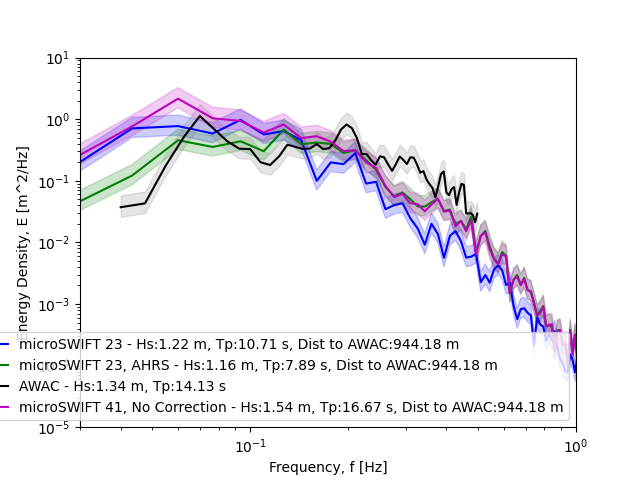

In [9]:
# mission 19, microSWIFT 23
# EKF
nearAWAC_mission19_microSWIFT23 = io.loadmat('./data/nearAWACData_mission19_microSWIFT_23.mat')
mission7_mission19_microSWIFT23_accel_x, mission19_microSWIFT23_accel_y, mission19_microSWIFT23_accel_z =  ekfCorrection(nearAWAC_mission19_microSWIFT23['a_x'][0], nearAWAC_mission19_microSWIFT23['a_y'][0], nearAWAC_mission19_microSWIFT23['a_z'][0], nearAWAC_mission19_microSWIFT23['gyro_x'][0], nearAWAC_mission19_microSWIFT23['gyro_y'][0], nearAWAC_mission19_microSWIFT23['gyro_z'][0], nearAWAC_mission19_microSWIFT23['mag_x'][0], nearAWAC_mission19_microSWIFT23['mag_y'][0], nearAWAC_mission19_microSWIFT23['mag_z'][0])
mission19_microSWIFT23_accel_z_filt, mission19_microSWIFT23_w, mission19_microSWIFT23_z, mission19_microSWIFT23_f, mission19_microSWIFT23_E, mission19_microSWIFT23_dof = processZAccel(mission19_microSWIFT23_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission19_microSWIFT23 = chi2.ppf([1 - alpha / 2, alpha / 2], mission19_microSWIFT23_dof)
c2_mission19_microSWIFT23 = mission19_microSWIFT23_dof / c_mission19_microSWIFT23
mission19_microSWIFT23_Hs, mission19_microSWIFT23_Tp = computeBulkWaveParameters(mission19_microSWIFT23_f, mission19_microSWIFT23_E)
mission19_microSWIFT23_dist2awac = avgDistToAWAC(nearAWAC_mission19_microSWIFT23['x'][0], nearAWAC_mission19_microSWIFT23['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission19_microSWIFT23_ahrs = io.loadmat('./data/ahrs_mission19_microSWIFT_23.mat')
mission19_microSWIFT23_accel_z_filt_ahrs, mission19_microSWIFT23_w_ahrs, mission19_microSWIFT23_z_ahrs, mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs, mission19_microSWIFT23_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission19_microSWIFT23_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission19_microSWIFT23_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission19_microSWIFT23_dof_ahrs)
c2_mission19_microSWIFT23_ahrs = mission19_microSWIFT23_dof_ahrs / c_mission19_microSWIFT23_ahrs
mission19_microSWIFT23_Hs_ahrs, mission19_microSWIFT23_Tp_ahrs = computeBulkWaveParameters(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs)
# No Correction 
mission19_microSWIFT23_nc_accel_z_filt, mission19_microSWIFT23_nc_w, mission19_microSWIFT23_nc_z, mission19_microSWIFT23_nc_f, mission19_microSWIFT23_nc_E, mission19_microSWIFT23_nc_dof = processZAccel(nearAWAC_mission19_microSWIFT23['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission19_microSWIFT23_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission19_microSWIFT23_nc_dof)
c2_mission19_microSWIFT23_nc = mission19_microSWIFT23_nc_dof / c_mission19_microSWIFT23_nc
mission19_microSWIFT23_nc_Hs, mission19_microSWIFT23_nc_Tp = computeBulkWaveParameters(mission19_microSWIFT23_nc_f, mission19_microSWIFT23_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission19, ax1 = plt.subplots()

# microSWIFT 23
ax1.loglog(mission19_microSWIFT23_f, mission19_microSWIFT23_E, color='b', label='microSWIFT 23 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission19_microSWIFT23_Hs, mission19_microSWIFT23_Tp, mission19_microSWIFT23_dist2awac))
ax1.fill_between(mission19_microSWIFT23_f, mission19_microSWIFT23_E*c2_mission19_microSWIFT23[0], mission19_microSWIFT23_E*c2_mission19_microSWIFT23[1], color='b', alpha=.2)
ax1.loglog(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs, color='g', label='microSWIFT 23, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission19_microSWIFT23_Hs_ahrs, mission19_microSWIFT23_Tp_ahrs, mission19_microSWIFT23_dist2awac))
ax1.fill_between(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs*c2_mission19_microSWIFT23_ahrs[0], mission19_microSWIFT23_E_ahrs*c2_mission19_microSWIFT23_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission19_microSWIFT23['f_awac'][0], nearAWAC_mission19_microSWIFT23['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0], nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission19_microSWIFT23['f_awac'][0], nearAWAC_mission19_microSWIFT23['E_awac'][0]*c2_awac[0], nearAWAC_mission19_microSWIFT23['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.loglog(mission19_microSWIFT23_nc_f, mission19_microSWIFT23_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission19_microSWIFT23_nc_Hs, mission19_microSWIFT23_nc_Tp, mission19_microSWIFT23_dist2awac))
ax1.fill_between(mission19_microSWIFT23_nc_f, mission19_microSWIFT23_nc_E*c2_mission19_microSWIFT23_nc[0], mission19_microSWIFT23_nc_E*c2_mission19_microSWIFT23_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

fig_mission19.savefig('./figures/mission19_validation.png')

<h3>Mission 26 Validation</h3>

Degrees of Freedom: 60.0
Degrees of Freedom: 60.0
Degrees of Freedom: 60.0


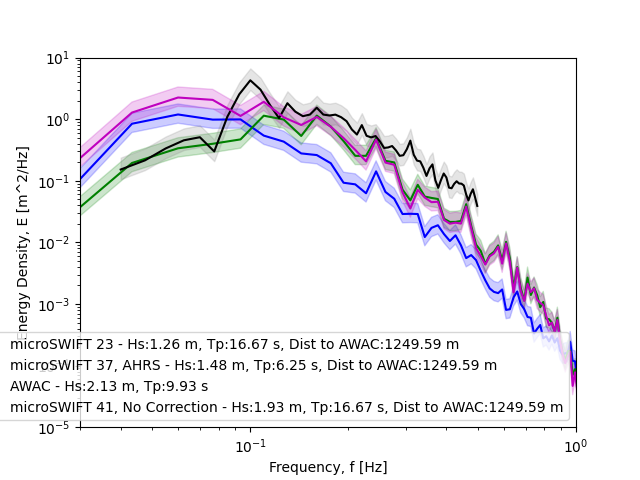

In [10]:
# mission 26, microSWIFT 37
# EKF
nearAWAC_mission26_microSWIFT37 = io.loadmat('./data/nearAWACData_mission26_microSWIFT_37.mat')
mission7_mission26_microSWIFT37_accel_x, mission26_microSWIFT37_accel_y, mission26_microSWIFT37_accel_z =  ekfCorrection(nearAWAC_mission26_microSWIFT37['a_x'][0], nearAWAC_mission26_microSWIFT37['a_y'][0], nearAWAC_mission26_microSWIFT37['a_z'][0], nearAWAC_mission26_microSWIFT37['gyro_x'][0], nearAWAC_mission26_microSWIFT37['gyro_y'][0], nearAWAC_mission26_microSWIFT37['gyro_z'][0], nearAWAC_mission26_microSWIFT37['mag_x'][0], nearAWAC_mission26_microSWIFT37['mag_y'][0], nearAWAC_mission26_microSWIFT37['mag_z'][0])
mission26_microSWIFT37_accel_z_filt, mission26_microSWIFT37_w, mission26_microSWIFT37_z, mission26_microSWIFT37_f, mission26_microSWIFT37_E, mission26_microSWIFT37_dof = processZAccel(mission26_microSWIFT37_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission26_microSWIFT37 = chi2.ppf([1 - alpha / 2, alpha / 2], mission26_microSWIFT37_dof)
c2_mission26_microSWIFT37 = mission26_microSWIFT37_dof / c_mission26_microSWIFT37
mission26_microSWIFT37_Hs, mission26_microSWIFT37_Tp = computeBulkWaveParameters(mission26_microSWIFT37_f, mission26_microSWIFT37_E)
mission26_microSWIFT37_dist2awac = avgDistToAWAC(nearAWAC_mission26_microSWIFT37['x'][0], nearAWAC_mission26_microSWIFT37['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission26_microSWIFT37_ahrs = io.loadmat('./data/ahrs_mission26_microSWIFT_37.mat')
mission26_microSWIFT37_accel_z_filt_ahrs, mission26_microSWIFT37_w_ahrs, mission26_microSWIFT37_z_ahrs, mission26_microSWIFT37_f_ahrs, mission26_microSWIFT37_E_ahrs, mission26_microSWIFT37_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission26_microSWIFT37_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission26_microSWIFT37_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission26_microSWIFT37_dof_ahrs)
c2_mission26_microSWIFT37_ahrs = mission26_microSWIFT37_dof_ahrs / c_mission26_microSWIFT37_ahrs
mission26_microSWIFT37_Hs_ahrs, mission26_microSWIFT37_Tp_ahrs = computeBulkWaveParameters(mission26_microSWIFT37_f_ahrs, mission26_microSWIFT37_E_ahrs)
# No Correction 
mission26_microSWIFT37_nc_accel_z_filt, mission26_microSWIFT37_nc_w, mission26_microSWIFT37_nc_z, mission26_microSWIFT37_nc_f, mission26_microSWIFT37_nc_E, mission26_microSWIFT37_nc_dof = processZAccel(nearAWAC_mission26_microSWIFT37['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission26_microSWIFT37_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission26_microSWIFT37_nc_dof)
c2_mission26_microSWIFT37_nc = mission26_microSWIFT37_nc_dof / c_mission26_microSWIFT37_nc
mission26_microSWIFT37_nc_Hs, mission26_microSWIFT37_nc_Tp = computeBulkWaveParameters(mission26_microSWIFT37_nc_f, mission26_microSWIFT37_nc_E)


# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission26, ax1 = plt.subplots()

# microSWIFT 23
ax1.loglog(mission26_microSWIFT37_f, mission26_microSWIFT37_E, color='b', label='microSWIFT 23 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission26_microSWIFT37_Hs, mission26_microSWIFT37_Tp, mission26_microSWIFT37_dist2awac))
ax1.fill_between(mission26_microSWIFT37_f, mission26_microSWIFT37_E*c2_mission26_microSWIFT37[0], mission26_microSWIFT37_E*c2_mission26_microSWIFT37[1], color='b', alpha=.2)
ax1.loglog(mission26_microSWIFT37_f_ahrs, mission26_microSWIFT37_E_ahrs, color='g', label='microSWIFT 37, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission26_microSWIFT37_Hs_ahrs, mission26_microSWIFT37_Tp_ahrs, mission26_microSWIFT37_dist2awac))
ax1.fill_between(mission26_microSWIFT37_f_ahrs, mission26_microSWIFT37_E_ahrs*c2_mission26_microSWIFT37_ahrs[0], mission26_microSWIFT37_E_ahrs*c2_mission26_microSWIFT37_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission26_microSWIFT37['f_awac'][0], nearAWAC_mission26_microSWIFT37['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0], nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission26_microSWIFT37['f_awac'][0], nearAWAC_mission26_microSWIFT37['E_awac'][0]*c2_awac[0], nearAWAC_mission26_microSWIFT37['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.loglog(mission26_microSWIFT37_nc_f, mission26_microSWIFT37_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission26_microSWIFT37_nc_Hs, mission26_microSWIFT37_nc_Tp, mission26_microSWIFT37_dist2awac))
ax1.fill_between(mission26_microSWIFT37_nc_f, mission26_microSWIFT37_nc_E*c2_mission26_microSWIFT37_nc[0], mission26_microSWIFT37_nc_E*c2_mission26_microSWIFT37_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

fig_mission26.savefig('./figures/mission26_validation.png')

<h3>Mission 28 Validation</h3>

Degrees of Freedom: 104.0
Degrees of Freedom: 104.0
Degrees of Freedom: 104.0


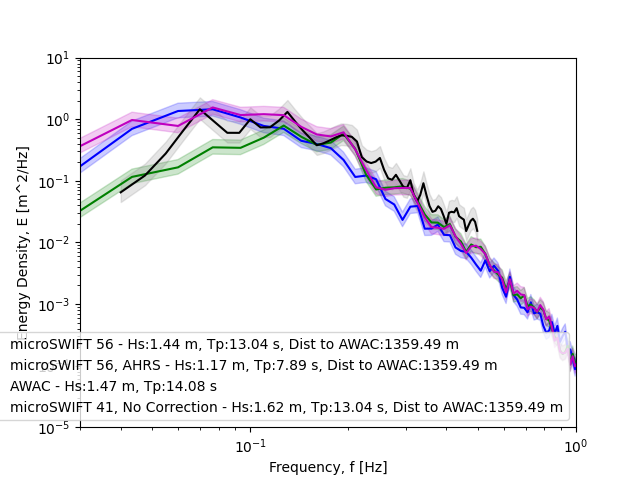

In [11]:
# mission 28, microSWIFT 56
# EKF
nearAWAC_mission28_microSWIFT56 = io.loadmat('./data/nearAWACData_mission28_microSWIFT_56.mat')
mission7_mission28_microSWIFT56_accel_x, mission28_microSWIFT56_accel_y, mission28_microSWIFT56_accel_z =  ekfCorrection(nearAWAC_mission28_microSWIFT56['a_x'][0], nearAWAC_mission28_microSWIFT56['a_y'][0], nearAWAC_mission28_microSWIFT56['a_z'][0], nearAWAC_mission28_microSWIFT56['gyro_x'][0], nearAWAC_mission28_microSWIFT56['gyro_y'][0], nearAWAC_mission28_microSWIFT56['gyro_z'][0], nearAWAC_mission28_microSWIFT56['mag_x'][0], nearAWAC_mission28_microSWIFT56['mag_y'][0], nearAWAC_mission28_microSWIFT56['mag_z'][0])
mission28_microSWIFT56_accel_z_filt, mission28_microSWIFT56_w, mission28_microSWIFT56_z, mission28_microSWIFT56_f, mission28_microSWIFT56_E, mission28_microSWIFT56_dof = processZAccel(mission28_microSWIFT56_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission28_microSWIFT56 = chi2.ppf([1 - alpha / 2, alpha / 2], mission28_microSWIFT56_dof)
c2_mission28_microSWIFT56 = mission28_microSWIFT56_dof / c_mission28_microSWIFT56
mission28_microSWIFT56_Hs, mission28_microSWIFT56_Tp = computeBulkWaveParameters(mission28_microSWIFT56_f, mission28_microSWIFT56_E)
mission28_microSWIFT56_dist2awac = avgDistToAWAC(nearAWAC_mission28_microSWIFT56['x'][0], nearAWAC_mission28_microSWIFT56['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission28_microSWIFT56_ahrs = io.loadmat('./data/ahrs_mission28_microSWIFT_56.mat')
mission28_microSWIFT56_accel_z_filt_ahrs, mission28_microSWIFT56_w_ahrs, mission28_microSWIFT56_z_ahrs, mission28_microSWIFT56_f_ahrs, mission28_microSWIFT56_E_ahrs, mission28_microSWIFT56_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission28_microSWIFT56_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission28_microSWIFT56_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission28_microSWIFT56_dof_ahrs)
c2_mission28_microSWIFT56_ahrs = mission28_microSWIFT56_dof_ahrs / c_mission28_microSWIFT56_ahrs
mission28_microSWIFT56_Hs_ahrs, mission28_microSWIFT56_Tp_ahrs = computeBulkWaveParameters(mission28_microSWIFT56_f_ahrs, mission28_microSWIFT56_E_ahrs)
# No Correction 
mission28_microSWIFT56_nc_accel_z_filt, mission28_microSWIFT56_nc_w, mission28_microSWIFT56_nc_z, mission28_microSWIFT56_nc_f, mission28_microSWIFT56_nc_E, mission28_microSWIFT56_nc_dof = processZAccel(nearAWAC_mission28_microSWIFT56['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission28_microSWIFT56_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission28_microSWIFT56_nc_dof)
c2_mission28_microSWIFT56_nc = mission28_microSWIFT56_nc_dof / c_mission28_microSWIFT56_nc
mission28_microSWIFT56_nc_Hs, mission28_microSWIFT56_nc_Tp = computeBulkWaveParameters(mission28_microSWIFT56_nc_f, mission28_microSWIFT56_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission28, ax1 = plt.subplots()

# microSWIFT 56
ax1.loglog(mission28_microSWIFT56_f, mission28_microSWIFT56_E, color='b', label='microSWIFT 56 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission28_microSWIFT56_Hs, mission28_microSWIFT56_Tp, mission28_microSWIFT56_dist2awac))
ax1.fill_between(mission28_microSWIFT56_f, mission28_microSWIFT56_E*c2_mission28_microSWIFT56[0], mission28_microSWIFT56_E*c2_mission28_microSWIFT56[1], color='b', alpha=.2)
ax1.loglog(mission28_microSWIFT56_f_ahrs, mission28_microSWIFT56_E_ahrs, color='g', label='microSWIFT 56, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission28_microSWIFT56_Hs_ahrs, mission28_microSWIFT56_Tp_ahrs, mission28_microSWIFT56_dist2awac))
ax1.fill_between(mission28_microSWIFT56_f_ahrs, mission28_microSWIFT56_E_ahrs*c2_mission28_microSWIFT56_ahrs[0], mission28_microSWIFT56_E_ahrs*c2_mission28_microSWIFT56_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission28_microSWIFT56['f_awac'][0], nearAWAC_mission28_microSWIFT56['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0], nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission28_microSWIFT56['f_awac'][0], nearAWAC_mission28_microSWIFT56['E_awac'][0]*c2_awac[0], nearAWAC_mission28_microSWIFT56['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.loglog(mission28_microSWIFT56_nc_f, mission28_microSWIFT56_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission28_microSWIFT56_nc_Hs, mission28_microSWIFT56_nc_Tp, mission28_microSWIFT56_dist2awac))
ax1.fill_between(mission28_microSWIFT56_nc_f, mission28_microSWIFT56_nc_E*c2_mission28_microSWIFT56_nc[0], mission28_microSWIFT56_nc_E*c2_mission28_microSWIFT56_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

fig_mission28.savefig('./figures/mission28_validation.png')

<h3>Mission 59 Validation</h3>

Degrees of Freedom: 54.0
Degrees of Freedom: 54.0
Degrees of Freedom: 54.0
Degrees of Freedom: 59.0
Degrees of Freedom: 59.0
Degrees of Freedom: 59.0


(1e-05, 10)

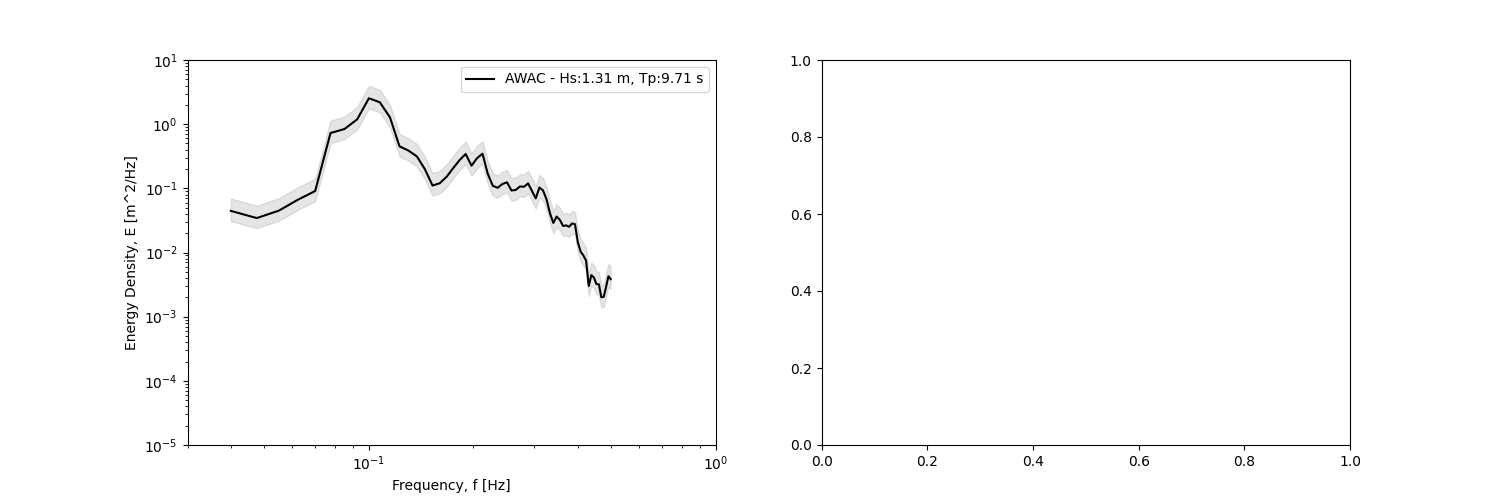

In [20]:
# mission 59, microSWIFT 20
# EKF
nearAWAC_mission59_microSWIFT20 = io.loadmat('./data/nearAWACData_mission59_microSWIFT_20.mat')
mission59_microSWIFT20_accel_x, mission59_microSWIFT20_accel_y, mission59_microSWIFT20_accel_z =  ekfCorrection(nearAWAC_mission59_microSWIFT20['a_x'][0], nearAWAC_mission59_microSWIFT20['a_y'][0], nearAWAC_mission59_microSWIFT20['a_z'][0], nearAWAC_mission59_microSWIFT20['gyro_x'][0], nearAWAC_mission59_microSWIFT20['gyro_y'][0], nearAWAC_mission59_microSWIFT20['gyro_z'][0], nearAWAC_mission59_microSWIFT20['mag_x'][0], nearAWAC_mission59_microSWIFT20['mag_y'][0], nearAWAC_mission59_microSWIFT20['mag_z'][0])
mission59_microSWIFT20_accel_z_filt, mission59_microSWIFT20_w, mission59_microSWIFT20_z, mission59_microSWIFT20_f, mission59_microSWIFT20_E, mission59_microSWIFT20_dof = processZAccel(mission59_microSWIFT20_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT20 = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT20_dof)
c2_mission59_microSWIFT20 = mission59_microSWIFT20_dof / c_mission59_microSWIFT20
mission59_microSWIFT20_Hs, mission59_microSWIFT20_Tp = computeBulkWaveParameters(mission59_microSWIFT20_f, mission59_microSWIFT20_E)
mission59_microSWIFT20_dist2awac = avgDistToAWAC(nearAWAC_mission59_microSWIFT20['x'][0], nearAWAC_mission59_microSWIFT20['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission59_microSWIFT20_ahrs = io.loadmat('./data/ahrs_mission59_microSWIFT_20.mat')
mission59_microSWIFT20_accel_z_filt_ahrs, mission59_microSWIFT20_w_ahrs, mission59_microSWIFT20_z_ahrs, mission59_microSWIFT20_f_ahrs, mission59_microSWIFT20_E_ahrs, mission59_microSWIFT20_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission59_microSWIFT20_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT20_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT20_dof_ahrs)
c2_mission59_microSWIFT20_ahrs = mission59_microSWIFT20_dof_ahrs / c_mission59_microSWIFT20_ahrs
mission59_microSWIFT20_Hs_ahrs, mission59_microSWIFT20_Tp_ahrs = computeBulkWaveParameters(mission59_microSWIFT20_f_ahrs, mission59_microSWIFT20_E_ahrs)
# No Correction 
mission59_microSWIFT20_nc_accel_z_filt, mission59_microSWIFT20_nc_w, mission59_microSWIFT20_nc_z, mission59_microSWIFT20_nc_f, mission59_microSWIFT20_nc_E, mission59_microSWIFT20_nc_dof = processZAccel(nearAWAC_mission59_microSWIFT20['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT20_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT20_nc_dof)
c2_mission59_microSWIFT20_nc = mission59_microSWIFT20_nc_dof / c_mission59_microSWIFT20_nc
mission59_microSWIFT20_nc_Hs, mission59_microSWIFT20_nc_Tp = computeBulkWaveParameters(mission59_microSWIFT20_nc_f, mission59_microSWIFT20_nc_E)

# mission 59, microSWIFT 23
# EKF
nearAWAC_mission59_microSWIFT23 = io.loadmat('./data/nearAWACData_mission59_microSWIFT_23.mat')
mission59_microSWIFT23_accel_x, mission59_microSWIFT23_accel_y, mission59_microSWIFT23_accel_z =  ekfCorrection(nearAWAC_mission59_microSWIFT23['a_x'][0], nearAWAC_mission59_microSWIFT23['a_y'][0], nearAWAC_mission59_microSWIFT23['a_z'][0], nearAWAC_mission59_microSWIFT23['gyro_x'][0], nearAWAC_mission59_microSWIFT23['gyro_y'][0], nearAWAC_mission59_microSWIFT23['gyro_z'][0], nearAWAC_mission59_microSWIFT23['mag_x'][0], nearAWAC_mission59_microSWIFT23['mag_y'][0], nearAWAC_mission59_microSWIFT23['mag_z'][0])
mission59_microSWIFT23_accel_z_filt, mission59_microSWIFT23_w, mission59_microSWIFT23_z, mission59_microSWIFT23_f, mission59_microSWIFT23_E, mission59_microSWIFT23_dof = processZAccel(mission59_microSWIFT23_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT23 = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT23_dof)
c2_mission59_microSWIFT23 = mission59_microSWIFT23_dof / c_mission59_microSWIFT23
mission59_microSWIFT23_Hs, mission59_microSWIFT23_Tp = computeBulkWaveParameters(mission59_microSWIFT23_f, mission59_microSWIFT23_E)
mission59_microSWIFT23_dist2awac = avgDistToAWAC(nearAWAC_mission59_microSWIFT23['x'][0], nearAWAC_mission59_microSWIFT23['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission59_microSWIFT23_ahrs = io.loadmat('./data/ahrs_mission59_microSWIFT_23.mat')
mission59_microSWIFT23_accel_z_filt_ahrs, mission59_microSWIFT23_w_ahrs, mission59_microSWIFT23_z_ahrs, mission59_microSWIFT23_f_ahrs, mission59_microSWIFT23_E_ahrs, mission59_microSWIFT23_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission59_microSWIFT23_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT23_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT23_dof_ahrs)
c2_mission59_microSWIFT23_ahrs = mission59_microSWIFT23_dof_ahrs / c_mission59_microSWIFT23_ahrs
mission59_microSWIFT23_Hs_ahrs, mission59_microSWIFT23_Tp_ahrs = computeBulkWaveParameters(mission59_microSWIFT23_f_ahrs, mission59_microSWIFT23_E_ahrs)
# No Correction 
mission59_microSWIFT23_nc_accel_z_filt, mission59_microSWIFT23_nc_w, mission59_microSWIFT23_nc_z, mission59_microSWIFT23_nc_f, mission59_microSWIFT23_nc_E, mission59_microSWIFT23_nc_dof = processZAccel(nearAWAC_mission59_microSWIFT23['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission59_microSWIFT23_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission59_microSWIFT23_nc_dof)
c2_mission59_microSWIFT23_nc = mission59_microSWIFT23_nc_dof / c_mission59_microSWIFT23_nc
mission59_microSWIFT23_nc_Hs, mission59_microSWIFT23_nc_Tp = computeBulkWaveParameters(mission59_microSWIFT23_nc_f, mission59_microSWIFT23_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
# fig_mission59, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
fig_mission59, ax1 = plt.subplots( figsize=(10,5))

# microSWIFT 20
# ax1.loglog(mission59_microSWIFT20_f, mission59_microSWIFT20_E, color='b', label='microSWIFT 20 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT20_Hs, mission59_microSWIFT20_Tp, mission59_microSWIFT20_dist2awac))
# ax1.fill_between(mission59_microSWIFT20_f, mission59_microSWIFT20_E*c2_mission59_microSWIFT20[0], mission59_microSWIFT20_E*c2_mission59_microSWIFT20[1], color='b', alpha=.2)
# ax1.loglog(mission59_microSWIFT20_f_ahrs, mission59_microSWIFT20_E_ahrs, color='g', label='microSWIFT 56, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT20_Hs_ahrs, mission59_microSWIFT20_Tp_ahrs, mission59_microSWIFT20_dist2awac))
# ax1.fill_between(mission59_microSWIFT20_f_ahrs, mission59_microSWIFT20_E_ahrs*c2_mission59_microSWIFT20_ahrs[0], mission59_microSWIFT20_E_ahrs*c2_mission59_microSWIFT20_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission59_microSWIFT20['f_awac'][0], nearAWAC_mission59_microSWIFT20['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0], nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission59_microSWIFT20['f_awac'][0], nearAWAC_mission59_microSWIFT20['E_awac'][0]*c2_awac[0], nearAWAC_mission59_microSWIFT20['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
# ax1.loglog(mission59_microSWIFT20_nc_f, mission59_microSWIFT20_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT20_nc_Hs, mission59_microSWIFT20_nc_Tp, mission59_microSWIFT20_dist2awac))
# ax1.fill_between(mission59_microSWIFT20_nc_f, mission59_microSWIFT20_nc_E*c2_mission59_microSWIFT20_nc[0], mission59_microSWIFT20_nc_E*c2_mission59_microSWIFT20_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

# # microSWIFT 23
# ax2.loglog(mission59_microSWIFT23_f, mission59_microSWIFT23_E, color='b', label='microSWIFT 23 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT23_Hs, mission59_microSWIFT23_Tp, mission59_microSWIFT23_dist2awac))
# ax2.fill_between(mission59_microSWIFT23_f, mission59_microSWIFT23_E*c2_mission59_microSWIFT23[0], mission59_microSWIFT23_E*c2_mission59_microSWIFT23[1], color='b', alpha=.2)
# ax2.loglog(mission59_microSWIFT23_f_ahrs, mission59_microSWIFT23_E_ahrs, color='g', label='microSWIFT 56, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT23_Hs_ahrs, mission59_microSWIFT23_Tp_ahrs, mission59_microSWIFT23_dist2awac))
# ax2.fill_between(mission59_microSWIFT23_f_ahrs, mission59_microSWIFT23_E_ahrs*c2_mission59_microSWIFT23_ahrs[0], mission59_microSWIFT23_E_ahrs*c2_mission59_microSWIFT23_ahrs[1], color='g', alpha=.2)
# ax2.loglog(nearAWAC_mission59_microSWIFT23['f_awac'][0], nearAWAC_mission59_microSWIFT23['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0], nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0]))
# ax2.fill_between(nearAWAC_mission59_microSWIFT23['f_awac'][0], nearAWAC_mission59_microSWIFT23['E_awac'][0]*c2_awac[0], nearAWAC_mission59_microSWIFT23['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
# ax2.loglog(mission59_microSWIFT23_nc_f, mission59_microSWIFT23_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission59_microSWIFT23_nc_Hs, mission59_microSWIFT23_nc_Tp, mission59_microSWIFT23_dist2awac))
# ax2.fill_between(mission59_microSWIFT23_nc_f, mission59_microSWIFT23_nc_E*c2_mission59_microSWIFT23_nc[0], mission59_microSWIFT23_nc_E*c2_mission59_microSWIFT23_nc[1], color='m', alpha=.2)
# ax2.set_xlabel('Frequency, f [Hz]')
# ax2.set_ylabel('Energy Density, E [m^2/Hz]')
# ax2.legend()
# ax2.set_xlim(0.03, 1)
# ax2.set_ylim(10**-5, 10)

# fig_mission59.savefig('./figures/mission59_validation.png')

<h3>Mission 60 Validation</h3>

Degrees of Freedom: 59.0
Degrees of Freedom: 59.0
Degrees of Freedom: 59.0


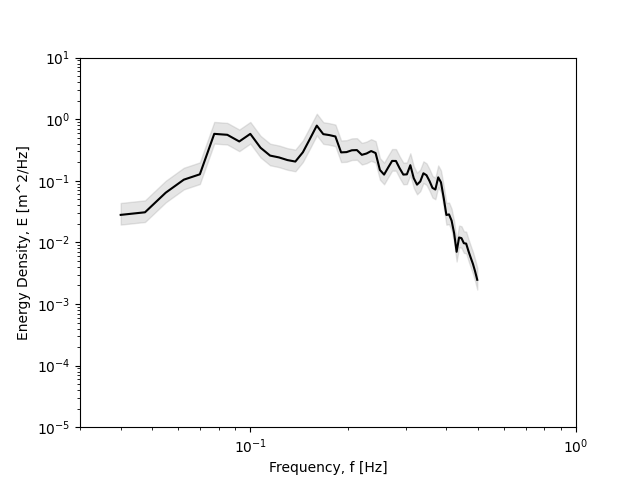

In [19]:
# mission 60, microSWIFT 71
# EKF
nearAWAC_mission60_microSWIFT71 = io.loadmat('./data/nearAWACData_mission60_microSWIFT_71.mat')
mission7_mission60_microSWIFT71_accel_x, mission60_microSWIFT71_accel_y, mission60_microSWIFT71_accel_z =  ekfCorrection(nearAWAC_mission60_microSWIFT71['a_x'][0], nearAWAC_mission60_microSWIFT71['a_y'][0], nearAWAC_mission60_microSWIFT71['a_z'][0], nearAWAC_mission60_microSWIFT71['gyro_x'][0], nearAWAC_mission60_microSWIFT71['gyro_y'][0], nearAWAC_mission60_microSWIFT71['gyro_z'][0], nearAWAC_mission60_microSWIFT71['mag_x'][0], nearAWAC_mission60_microSWIFT71['mag_y'][0], nearAWAC_mission60_microSWIFT71['mag_z'][0])
mission60_microSWIFT71_accel_z_filt, mission60_microSWIFT71_w, mission60_microSWIFT71_z, mission60_microSWIFT71_f, mission60_microSWIFT71_E, mission60_microSWIFT71_dof = processZAccel(mission60_microSWIFT71_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission60_microSWIFT71 = chi2.ppf([1 - alpha / 2, alpha / 2], mission60_microSWIFT71_dof)
c2_mission60_microSWIFT71 = mission60_microSWIFT71_dof / c_mission60_microSWIFT71
mission60_microSWIFT71_Hs, mission60_microSWIFT71_Tp = computeBulkWaveParameters(mission60_microSWIFT71_f, mission60_microSWIFT71_E)
mission60_microSWIFT71_dist2awac = avgDistToAWAC(nearAWAC_mission60_microSWIFT71['x'][0], nearAWAC_mission60_microSWIFT71['y'][0], xFRF_awac, yFRF_awac)
# AHRS
nearAWAC_mission60_microSWIFT71_ahrs = io.loadmat('./data/ahrs_mission60_microSWIFT_71.mat')
mission60_microSWIFT71_accel_z_filt_ahrs, mission60_microSWIFT71_w_ahrs, mission60_microSWIFT71_z_ahrs, mission60_microSWIFT71_f_ahrs, mission60_microSWIFT71_E_ahrs, mission60_microSWIFT71_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission60_microSWIFT71_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission60_microSWIFT71_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission60_microSWIFT71_dof_ahrs)
c2_mission60_microSWIFT71_ahrs = mission60_microSWIFT71_dof_ahrs / c_mission60_microSWIFT71_ahrs
mission60_microSWIFT71_Hs_ahrs, mission60_microSWIFT71_Tp_ahrs = computeBulkWaveParameters(mission60_microSWIFT71_f_ahrs, mission60_microSWIFT71_E_ahrs)
# No Correction 
mission60_microSWIFT71_nc_accel_z_filt, mission60_microSWIFT71_nc_w, mission60_microSWIFT71_nc_z, mission60_microSWIFT71_nc_f, mission60_microSWIFT71_nc_E, mission60_microSWIFT71_nc_dof = processZAccel(nearAWAC_mission60_microSWIFT71['a_z'][0], fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission60_microSWIFT71_nc = chi2.ppf([1 - alpha / 2, alpha / 2], mission60_microSWIFT71_nc_dof)
c2_mission60_microSWIFT71_nc = mission60_microSWIFT71_nc_dof / c_mission60_microSWIFT71_nc
mission60_microSWIFT71_nc_Hs, mission60_microSWIFT71_nc_Tp = computeBulkWaveParameters(mission60_microSWIFT71_nc_f, mission60_microSWIFT71_nc_E)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_mission60, ax1 = plt.subplots()

# microSWIFT 71
ax1.loglog(mission60_microSWIFT71_f, mission60_microSWIFT71_E, color='b', label='microSWIFT 71 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission60_microSWIFT71_Hs, mission60_microSWIFT71_Tp, mission60_microSWIFT71_dist2awac))
ax1.fill_between(mission60_microSWIFT71_f, mission60_microSWIFT71_E*c2_mission60_microSWIFT71[0], mission60_microSWIFT71_E*c2_mission60_microSWIFT71[1], color='b', alpha=.2)
ax1.loglog(mission60_microSWIFT71_f_ahrs, mission60_microSWIFT71_E_ahrs, color='g', label='microSWIFT 56, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission60_microSWIFT71_Hs_ahrs, mission60_microSWIFT71_Tp_ahrs, mission60_microSWIFT71_dist2awac))
ax1.fill_between(mission60_microSWIFT71_f_ahrs, mission60_microSWIFT71_E_ahrs*c2_mission60_microSWIFT71_ahrs[0], mission60_microSWIFT71_E_ahrs*c2_mission60_microSWIFT71_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission60_microSWIFT71['f_awac'][0], nearAWAC_mission60_microSWIFT71['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0], nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission60_microSWIFT71['f_awac'][0], nearAWAC_mission60_microSWIFT71['E_awac'][0]*c2_awac[0], nearAWAC_mission60_microSWIFT71['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.loglog(mission60_microSWIFT71_nc_f, mission60_microSWIFT71_nc_E, color='m', label='microSWIFT 41, No Correction - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission60_microSWIFT71_nc_Hs, mission60_microSWIFT71_nc_Tp, mission60_microSWIFT71_dist2awac))
ax1.fill_between(mission60_microSWIFT71_nc_f, mission60_microSWIFT71_nc_E*c2_mission60_microSWIFT71_nc[0], mission60_microSWIFT71_nc_E*c2_mission60_microSWIFT71_nc[1], color='m', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

fig_mission60.savefig('./figures/mission60_validation.png')

In [14]:
# Build Spreadsheet of all statistics
from openpyxl import Workbook
workbook = Workbook()  
sheet = workbook.active

# Create Headings for the spreadsheet
sheet['A1'] = "Mission Number"
sheet['B1'] = "microSWIFT Number"
sheet['C1'] = 'Average Distance from AWAC [m]'
# Hs
sheet['D1'] = 'EKF Hs [m]'
sheet['E1'] = 'AHRS Hs [m]'
sheet['F1'] = 'AWAC Hs [m]'
sheet['G1'] = 'EKF Hs Error [m]'
sheet['H1'] = 'AHRS Hs Error [m]'

# Tp
sheet['I1'] = 'EKF Tp [seconds]'
sheet['J1'] = 'AHRS Tp [seconds]'
sheet['K1'] = 'AWAC Tp [seconds]'
sheet['L1'] = 'EKF Tp Error [seconds]'
sheet['M1'] = 'AHRS Tp Error [seconds]'


# Mission 7, microSWIFT 41
row_num = 2
sheet['A{}'.format(row_num)] = '7'
sheet['B{}'.format(row_num)] = '41'
sheet['C{}'.format(row_num)] = mission7_microSWIFT41_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission7_microSWIFT41_Hs
sheet['E{}'.format(row_num)] = mission7_microSWIFT41_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission7_microSWIFT41_Hs - nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission7_microSWIFT41_Hs_ahrs - nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission7_microSWIFT41_Tp
sheet['J{}'.format(row_num)] = mission7_microSWIFT41_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission7_microSWIFT41_Tp - nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission7_microSWIFT41_Tp_ahrs - nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0])

# Mission 7, microSWIFT 57
row_num = 3
sheet['A{}'.format(row_num)] = '7'
sheet['B{}'.format(row_num)] = '57'
sheet['C{}'.format(row_num)] = mission7_microSWIFT57_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission7_microSWIFT57_Hs
sheet['E{}'.format(row_num)] = mission7_microSWIFT57_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission7_microSWIFT57_Hs - nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission7_microSWIFT57_Hs_ahrs - nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission7_microSWIFT57_Tp
sheet['J{}'.format(row_num)] = mission7_microSWIFT57_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission7_microSWIFT57_Tp - nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission7_microSWIFT57_Tp_ahrs - nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0])

# Mission 18, microSWIFT 4
row_num = 4
sheet['A{}'.format(row_num)] = '18'
sheet['B{}'.format(row_num)] = '4'
sheet['C{}'.format(row_num)] = mission18_microSWIFT4_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission18_microSWIFT4_Hs
sheet['E{}'.format(row_num)] = mission18_microSWIFT4_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission18_microSWIFT4_Hs - nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission18_microSWIFT4_Hs_ahrs - nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission18_microSWIFT4_Tp
sheet['J{}'.format(row_num)] = mission18_microSWIFT4_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission18_microSWIFT4_Tp - nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission18_microSWIFT4_Tp_ahrs - nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0])

# Mission 18, microSWIFT 5
row_num = 5
sheet['A{}'.format(row_num)] = '18'
sheet['B{}'.format(row_num)] = '5'
sheet['C{}'.format(row_num)] = mission18_microSWIFT5_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission18_microSWIFT5_Hs
sheet['E{}'.format(row_num)] = mission18_microSWIFT5_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission18_microSWIFT5_Hs - nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission18_microSWIFT5_Hs_ahrs - nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission18_microSWIFT5_Tp
sheet['J{}'.format(row_num)] = mission18_microSWIFT5_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission18_microSWIFT5_Tp - nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission18_microSWIFT5_Tp_ahrs - nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0])

# Mission 18, microSWIFT 12
row_num = 6
sheet['A{}'.format(row_num)] = '18'
sheet['B{}'.format(row_num)] = '12'
sheet['C{}'.format(row_num)] = mission18_microSWIFT12_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission18_microSWIFT12_Hs
sheet['E{}'.format(row_num)] = mission18_microSWIFT12_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission18_microSWIFT12_Hs - nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission18_microSWIFT12_Hs_ahrs - nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission18_microSWIFT12_Tp
sheet['J{}'.format(row_num)] = mission18_microSWIFT12_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission18_microSWIFT12_Tp - nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission18_microSWIFT12_Tp_ahrs - nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0])

# Mission 18, microSWIFT 13
row_num = 7
sheet['A{}'.format(row_num)] = '18'
sheet['B{}'.format(row_num)] = '13'
sheet['C{}'.format(row_num)] = mission18_microSWIFT13_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission18_microSWIFT13_Hs
sheet['E{}'.format(row_num)] = mission18_microSWIFT13_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission18_microSWIFT13_Hs - nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission18_microSWIFT13_Hs_ahrs - nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission18_microSWIFT13_Tp
sheet['J{}'.format(row_num)] = mission18_microSWIFT13_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission18_microSWIFT13_Tp - nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission18_microSWIFT13_Tp_ahrs - nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0])

# Mission 18, microSWIFT 23
row_num = 8
sheet['A{}'.format(row_num)] = '18'
sheet['B{}'.format(row_num)] = '23'
sheet['C{}'.format(row_num)] = mission18_microSWIFT23_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission18_microSWIFT23_Hs
sheet['E{}'.format(row_num)] = mission18_microSWIFT23_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission18_microSWIFT23_Hs - nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission18_microSWIFT23_Hs_ahrs - nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission18_microSWIFT23_Tp
sheet['J{}'.format(row_num)] = mission18_microSWIFT23_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission18_microSWIFT23_Tp - nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission18_microSWIFT23_Tp_ahrs - nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0])

# Mission 19, microSWIFT 23
row_num = 9
sheet['A{}'.format(row_num)] = '19'
sheet['B{}'.format(row_num)] = '23'
sheet['C{}'.format(row_num)] = mission19_microSWIFT23_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission19_microSWIFT23_Hs
sheet['E{}'.format(row_num)] = mission19_microSWIFT23_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission19_microSWIFT23_Hs - nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission19_microSWIFT23_Hs_ahrs - nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission19_microSWIFT23_Tp
sheet['J{}'.format(row_num)] = mission19_microSWIFT23_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission19_microSWIFT23_Tp - nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission19_microSWIFT23_Tp_ahrs - nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0])

# Mission 26, microSWIFT 37
row_num = 10
sheet['A{}'.format(row_num)] = '26'
sheet['B{}'.format(row_num)] = '37'
sheet['C{}'.format(row_num)] = mission26_microSWIFT37_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission26_microSWIFT37_Hs
sheet['E{}'.format(row_num)] = mission26_microSWIFT37_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission26_microSWIFT37_Hs - nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission26_microSWIFT37_Hs_ahrs - nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission26_microSWIFT37_Tp
sheet['J{}'.format(row_num)] = mission26_microSWIFT37_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission26_microSWIFT37_Tp - nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission26_microSWIFT37_Tp_ahrs - nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0])

# Mission 28, microSWIFT 56
row_num = 11
sheet['A{}'.format(row_num)] = '28'
sheet['B{}'.format(row_num)] = '56'
sheet['C{}'.format(row_num)] = mission28_microSWIFT56_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission28_microSWIFT56_Hs
sheet['E{}'.format(row_num)] = mission28_microSWIFT56_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission28_microSWIFT56_Hs - nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission28_microSWIFT56_Hs_ahrs - nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission28_microSWIFT56_Tp
sheet['J{}'.format(row_num)] = mission28_microSWIFT56_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission28_microSWIFT56_Tp - nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission28_microSWIFT56_Tp_ahrs - nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0])

# Mission 59, microSWIFT 20
row_num = 12
sheet['A{}'.format(row_num)] = '59'
sheet['B{}'.format(row_num)] = '20'
sheet['C{}'.format(row_num)] = mission59_microSWIFT20_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission59_microSWIFT20_Hs
sheet['E{}'.format(row_num)] = mission59_microSWIFT20_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission59_microSWIFT20_Hs - nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission59_microSWIFT20_Hs_ahrs - nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission59_microSWIFT20_Tp
sheet['J{}'.format(row_num)] = mission59_microSWIFT20_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission59_microSWIFT20_Tp - nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission59_microSWIFT20_Tp_ahrs - nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0])

# Mission 59, microSWIFT 20
row_num = 13
sheet['A{}'.format(row_num)] = '59'
sheet['B{}'.format(row_num)] = '23'
sheet['C{}'.format(row_num)] = mission59_microSWIFT23_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission59_microSWIFT23_Hs
sheet['E{}'.format(row_num)] = mission59_microSWIFT23_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission59_microSWIFT23_Hs - nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission59_microSWIFT23_Hs_ahrs - nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission59_microSWIFT23_Tp
sheet['J{}'.format(row_num)] = mission59_microSWIFT23_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission59_microSWIFT23_Tp - nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission59_microSWIFT23_Tp_ahrs - nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0])

# Mission 60, microSWIFT 71
row_num = 14
sheet['A{}'.format(row_num)] = '60'
sheet['B{}'.format(row_num)] = '71'
sheet['C{}'.format(row_num)] = mission60_microSWIFT71_dist2awac
# Hs
sheet['D{}'.format(row_num)] = mission60_microSWIFT71_Hs
sheet['E{}'.format(row_num)] = mission60_microSWIFT71_Hs_ahrs
sheet['F{}'.format(row_num)] = nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0]
sheet['G{}'.format(row_num)] = (mission60_microSWIFT71_Hs - nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0])
sheet['H{}'.format(row_num)] = (mission60_microSWIFT71_Hs_ahrs - nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0])
# Tp
sheet['I{}'.format(row_num)] = mission60_microSWIFT71_Tp
sheet['J{}'.format(row_num)] = mission60_microSWIFT71_Tp_ahrs
sheet['K{}'.format(row_num)] = nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0]
sheet['L{}'.format(row_num)] = (mission60_microSWIFT71_Tp - nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0])
sheet['M{}'.format(row_num)] = (mission60_microSWIFT71_Tp_ahrs - nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0])

# Compute Total Statistics 
sheet['F15'] = 'Average Error'
sheet['F16'] = 'Lower Bound, 95% Confidence Interval'
sheet['F17'] = 'Upper Bound, 95% Confidence Interval'

# EKF Hs stats
sheet['G15'] = '=AVERAGE(G2:G14)'
sheet['G16'] = '=AVERAGE(G2:G14) - 2*STDEV(G2:G14)'
sheet['G17'] = '=AVERAGE(G2:G14) + 2*STDEV(G2:G14)'

# AHRS Hs stats
sheet['H15'] = '=AVERAGE(H2:H14)'
sheet['H16'] = '=AVERAGE(H2:H14) - 2*STDEV(H2:H14)'
sheet['H17'] = '=AVERAGE(H2:H14) + 2*STDEV(H2:H14)'

# EKF Tp stats 
sheet['L15'] = '=AVERAGE(L2:L14)'
sheet['L16'] = '=AVERAGE(L2:L14) - 2*STDEV(L2:L14)'
sheet['L17'] = '=AVERAGE(L2:L14) + 2*STDEV(L2:L14)'

# EKF Tp stats 
sheet['M15'] = '=AVERAGE(M2:M14)'
sheet['M16'] = '=AVERAGE(M2:M14) - 2*STDEV(M2:M14)'
sheet['M17'] = '=AVERAGE(M2:M14) + 2*STDEV(M2:M14)'

# Save the Work book
workbook.save(filename="AWACValidationStatistics.xlsx")

In [15]:
# Average error of bulk parameters
# Hs
Hs_errors_ekf = []
Hs_errors_ahrs = []
Hs_errors_nc = []

# Mission 7, microSWIFT 41
Hs_errors_ekf.append(mission7_microSWIFT41_Hs - nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission7_microSWIFT41_Hs_ahrs - nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0])
Hs_errors_nc.append(mission7_microSWIFT41_nc_Hs - nearAWAC_mission7_microSWIFT41['Hs_awac'][0][0])

# Mission 7, microSWIFT 57
Hs_errors_ekf.append(mission7_microSWIFT57_Hs - nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission7_microSWIFT57_Hs_ahrs - nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0])
Hs_errors_nc.append(mission7_microSWIFT57_nc_Hs - nearAWAC_mission7_microSWIFT57['Hs_awac'][0][0])

# Mission 18, microSWIFT 4
Hs_errors_ekf.append(mission18_microSWIFT4_Hs - nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission18_microSWIFT4_Hs_ahrs - nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0])
Hs_errors_nc.append(mission18_microSWIFT4_nc_Hs - nearAWAC_mission18_microSWIFT4['Hs_awac'][0][0])

# Mission 18, microSWIFT 5
Hs_errors_ekf.append(mission18_microSWIFT5_Hs - nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission18_microSWIFT5_Hs - nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0])
Hs_errors_nc.append(mission18_microSWIFT5_Hs - nearAWAC_mission18_microSWIFT5['Hs_awac'][0][0])

# Mission 18, microSWIFT 12
Hs_errors_ekf.append(mission18_microSWIFT12_Hs - nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission18_microSWIFT12_Hs_ahrs - nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0])
Hs_errors_nc.append(mission18_microSWIFT12_nc_Hs - nearAWAC_mission18_microSWIFT12['Hs_awac'][0][0])

# Mission 18, microSWIFT 13
Hs_errors_ekf.append(mission18_microSWIFT13_Hs - nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission18_microSWIFT13_Hs_ahrs - nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0])
Hs_errors_nc.append(mission18_microSWIFT13_nc_Hs - nearAWAC_mission18_microSWIFT13['Hs_awac'][0][0])

# Mission 18, microSWIFT 23
Hs_errors_ekf.append(mission18_microSWIFT23_Hs - nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission18_microSWIFT23_Hs_ahrs - nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0])
Hs_errors_nc.append(mission18_microSWIFT23_nc_Hs - nearAWAC_mission18_microSWIFT23['Hs_awac'][0][0])

# Mission 19, microSWIFT 23
Hs_errors_ekf.append(mission19_microSWIFT23_Hs - nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission19_microSWIFT23_Hs_ahrs - nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0])
Hs_errors_nc.append(mission19_microSWIFT23_nc_Hs - nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0])

# Mission 26, microSWIFT 37
Hs_errors_ekf.append(mission26_microSWIFT37_Hs - nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission26_microSWIFT37_Hs_ahrs - nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0])
Hs_errors_nc.append(mission26_microSWIFT37_nc_Hs - nearAWAC_mission26_microSWIFT37['Hs_awac'][0][0])

# Mission 28, microSWIFT 56
Hs_errors_ekf.append(mission28_microSWIFT56_Hs - nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission28_microSWIFT56_Hs_ahrs - nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0])
Hs_errors_nc.append(mission28_microSWIFT56_nc_Hs - nearAWAC_mission28_microSWIFT56['Hs_awac'][0][0])

# Mission 59, microSWIFT 20
Hs_errors_ekf.append(mission59_microSWIFT20_Hs - nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission59_microSWIFT20_Hs_ahrs - nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0])
Hs_errors_nc.append(mission59_microSWIFT20_nc_Hs - nearAWAC_mission59_microSWIFT20['Hs_awac'][0][0])

# Mission 59, microSWIFT 23
Hs_errors_ekf.append(mission59_microSWIFT23_Hs - nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission59_microSWIFT23_Hs_ahrs - nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0])
Hs_errors_nc.append(mission59_microSWIFT23_nc_Hs - nearAWAC_mission59_microSWIFT23['Hs_awac'][0][0])

# Mission 60, microSWIFT 71
Hs_errors_ekf.append(mission60_microSWIFT71_Hs - nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0])
Hs_errors_ahrs.append(mission60_microSWIFT71_Hs_ahrs - nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0])
Hs_errors_nc.append(mission60_microSWIFT71_nc_Hs - nearAWAC_mission60_microSWIFT71['Hs_awac'][0][0])

# Average Hs Error 
Hs_error_ekf_avg = np.mean(Hs_errors_ekf)
Hs_error_ahrs_avg = np.mean(Hs_errors_ahrs)
Hs_error_nc_avg = np.mean(Hs_errors_nc)

print('Hs EKF Error Avg: {}'.format(Hs_error_ekf_avg))
print('Hs AHRS Error Avg: {}'.format(Hs_error_ahrs_avg))
print('Hs NC Error Avg: {}'.format(Hs_error_nc_avg))

# Tp 
Tp_errors_ekf = []
Tp_errors_ahrs = []
Tp_errors_nc = []

# Mission 7, microSWIFT 41
Tp_errors_ekf.append(mission7_microSWIFT41_Tp - nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission7_microSWIFT41_Tp_ahrs - nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0])
Tp_errors_nc.append(mission7_microSWIFT41_nc_Tp - nearAWAC_mission7_microSWIFT41['Tp_awac'][0][0])

# Mission 7, microSWIFT 57
Tp_errors_ekf.append(mission7_microSWIFT57_Tp - nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission7_microSWIFT57_Tp_ahrs - nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0])
Tp_errors_nc.append(mission7_microSWIFT57_nc_Tp - nearAWAC_mission7_microSWIFT57['Tp_awac'][0][0])

# Mission 18, microSWIFT 4
Tp_errors_ekf.append(mission18_microSWIFT4_Tp - nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission18_microSWIFT4_Tp_ahrs - nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0])
Tp_errors_nc.append(mission18_microSWIFT4_nc_Tp - nearAWAC_mission18_microSWIFT4['Tp_awac'][0][0])

# Mission 18, microSWIFT 5
Tp_errors_ekf.append(mission18_microSWIFT5_Tp - nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission18_microSWIFT5_Tp - nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0])
Tp_errors_nc.append(mission18_microSWIFT5_Tp - nearAWAC_mission18_microSWIFT5['Tp_awac'][0][0])

# Mission 18, microSWIFT 12
Tp_errors_ekf.append(mission18_microSWIFT12_Tp - nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission18_microSWIFT12_Tp_ahrs - nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0])
Tp_errors_nc.append(mission18_microSWIFT12_nc_Tp - nearAWAC_mission18_microSWIFT12['Tp_awac'][0][0])

# Mission 18, microSWIFT 13
Tp_errors_ekf.append(mission18_microSWIFT13_Tp - nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission18_microSWIFT13_Tp_ahrs - nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0])
Tp_errors_nc.append(mission18_microSWIFT13_nc_Tp - nearAWAC_mission18_microSWIFT13['Tp_awac'][0][0])

# Mission 18, microSWIFT 23
Tp_errors_ekf.append(mission18_microSWIFT23_Tp - nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission18_microSWIFT23_Tp_ahrs - nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0])
Tp_errors_nc.append(mission18_microSWIFT23_nc_Tp - nearAWAC_mission18_microSWIFT23['Tp_awac'][0][0])

# Mission 19, microSWIFT 23
Tp_errors_ekf.append(mission19_microSWIFT23_Tp - nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission19_microSWIFT23_Tp_ahrs - nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0])
Tp_errors_nc.append(mission19_microSWIFT23_nc_Tp - nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0])

# Mission 26, microSWIFT 37
Tp_errors_ekf.append(mission26_microSWIFT37_Tp - nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission26_microSWIFT37_Tp_ahrs - nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0])
Tp_errors_nc.append(mission26_microSWIFT37_nc_Tp - nearAWAC_mission26_microSWIFT37['Tp_awac'][0][0])

# Mission 28, microSWIFT 56
Tp_errors_ekf.append(mission28_microSWIFT56_Tp - nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission28_microSWIFT56_Tp_ahrs - nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0])
Tp_errors_nc.append(mission28_microSWIFT56_nc_Tp - nearAWAC_mission28_microSWIFT56['Tp_awac'][0][0])

# Mission 59, microSWIFT 20
Tp_errors_ekf.append(mission59_microSWIFT20_Tp - nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission59_microSWIFT20_Tp_ahrs - nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0])
Tp_errors_nc.append(mission59_microSWIFT20_nc_Tp - nearAWAC_mission59_microSWIFT20['Tp_awac'][0][0])

# Mission 59, microSWIFT 23
Tp_errors_ekf.append(mission59_microSWIFT23_Tp - nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission59_microSWIFT23_Tp_ahrs - nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0])
Tp_errors_nc.append(mission59_microSWIFT23_nc_Tp - nearAWAC_mission59_microSWIFT23['Tp_awac'][0][0])

# Mission 60, microSWIFT 71
Tp_errors_ekf.append(mission60_microSWIFT71_Tp - nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0])
Tp_errors_ahrs.append(mission60_microSWIFT71_Tp_ahrs - nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0])
Tp_errors_nc.append(mission60_microSWIFT71_nc_Tp - nearAWAC_mission60_microSWIFT71['Tp_awac'][0][0])

# Average Tp Error 
Tp_error_ekf_avg = np.mean(Tp_errors_ekf)
Tp_error_ahrs_avg = np.mean(Tp_errors_ahrs)
Tp_error_nc_avg = np.mean(Tp_errors_nc)

print('Tp EKF Error Avg: {}'.format(Tp_error_ekf_avg))
print('Tp AHRS Error Avg: {}'.format(Tp_error_ahrs_avg))
print('Tp NC Error Avg: {}'.format(Tp_error_nc_avg))

Hs EKF Error Avg: 0.11337189502289623
Hs AHRS Error Avg: -0.10447690377484062
Hs NC Error Avg: 0.30568324196401436
Tp EKF Error Avg: 1.1919989143896468
Tp AHRS Error Avg: -3.131678951287699
Tp NC Error Avg: 1.4453687329768576


Average Error Across each Frequency

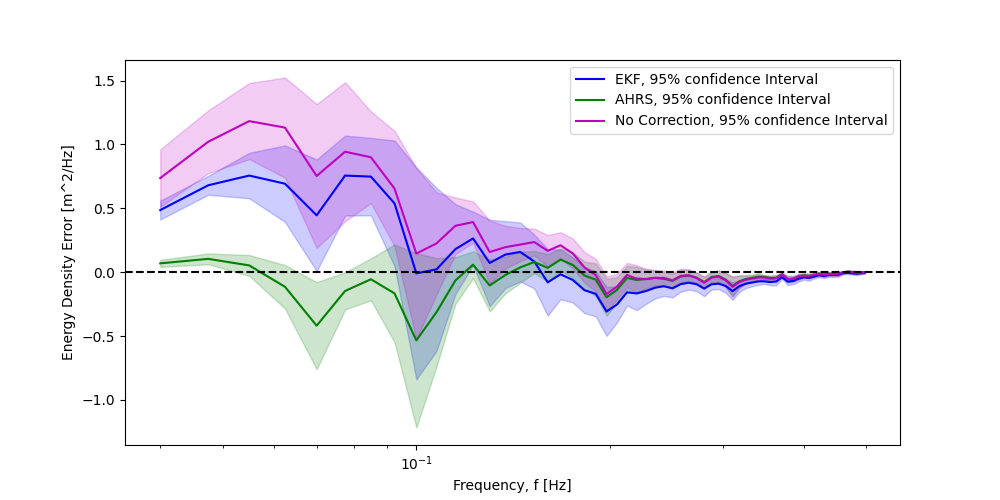

In [16]:
# Compare all microSWIFT frequency components by iterpolating the microSWIFT spectra
f_comparison = nearAWAC_mission7_microSWIFT41['f_awac'][0]

# mission 7, microSWIFT 41
# EKF
mission7_microSWIFT41_E_ekf_interp = np.interp(f_comparison, mission7_microSWIFT41_f, mission7_microSWIFT41_E)
mission7_microSWIFT41_E_ekf_error = mission7_microSWIFT41_E_ekf_interp - nearAWAC_mission7_microSWIFT41['E_awac'][0]
# ahrs
mission7_microSWIFT41_E_ahrs_interp = np.interp(f_comparison, mission7_microSWIFT41_f_ahrs, mission7_microSWIFT41_E_ahrs)
mission7_microSWIFT41_E_ahrs_error = mission7_microSWIFT41_E_ahrs_interp - nearAWAC_mission7_microSWIFT41['E_awac'][0]
# No Correction
mission7_microSWIFT41_nc_E_interp = np.interp(f_comparison, mission7_microSWIFT41_nc_f, mission7_microSWIFT41_nc_E)
mission7_microSWIFT41_nc_E_error = mission7_microSWIFT41_nc_E_interp - nearAWAC_mission7_microSWIFT41['E_awac'][0]

# mission 7, microSWIFT 57
# EKF
mission7_microSWIFT57_E_ekf_interp = np.interp(f_comparison, mission7_microSWIFT57_f, mission7_microSWIFT57_E)
mission7_microSWIFT57_E_ekf_error = mission7_microSWIFT57_E_ekf_interp - nearAWAC_mission7_microSWIFT57['E_awac'][0]
# ahrs
mission7_microSWIFT57_E_ahrs_interp = np.interp(f_comparison, mission7_microSWIFT57_f_ahrs, mission7_microSWIFT57_E_ahrs)
mission7_microSWIFT57_E_ahrs_error = mission7_microSWIFT57_E_ahrs_interp - nearAWAC_mission7_microSWIFT57['E_awac'][0]
# No Correction
mission7_microSWIFT57_nc_E_interp = np.interp(f_comparison, mission7_microSWIFT57_nc_f, mission7_microSWIFT57_nc_E)
mission7_microSWIFT57_nc_E_error = mission7_microSWIFT57_nc_E_interp - nearAWAC_mission7_microSWIFT57['E_awac'][0]

# mission 18, microSWIFT 4
# EKF
mission18_microSWIFT4_E_ekf_interp = np.interp(f_comparison, mission18_microSWIFT4_f, mission18_microSWIFT4_E)
mission18_microSWIFT4_E_ekf_error = mission18_microSWIFT4_E_ekf_interp - nearAWAC_mission18_microSWIFT4['E_awac'][0]
# ahrs
mission18_microSWIFT4_E_ahrs_interp = np.interp(f_comparison, mission18_microSWIFT4_f_ahrs, mission18_microSWIFT4_E_ahrs)
mission18_microSWIFT4_E_ahrs_error = mission18_microSWIFT4_E_ahrs_interp - nearAWAC_mission18_microSWIFT4['E_awac'][0]
# No Correction
mission18_microSWIFT4_nc_E_interp = np.interp(f_comparison, mission18_microSWIFT4_nc_f, mission18_microSWIFT4_nc_E)
mission18_microSWIFT4_nc_E_error = mission18_microSWIFT4_nc_E_interp - nearAWAC_mission18_microSWIFT4['E_awac'][0]

# mission 18, microSWIFT 5
# EKF
mission18_microSWIFT5_E_ekf_interp = np.interp(f_comparison, mission18_microSWIFT5_f, mission18_microSWIFT5_E)
mission18_microSWIFT5_E_ekf_error = mission18_microSWIFT5_E_ekf_interp - nearAWAC_mission18_microSWIFT5['E_awac'][0]
# ahrs
mission18_microSWIFT5_E_ahrs_interp = np.interp(f_comparison, mission18_microSWIFT5_f_ahrs, mission18_microSWIFT5_E_ahrs)
mission18_microSWIFT5_E_ahrs_error = mission18_microSWIFT5_E_ahrs_interp - nearAWAC_mission18_microSWIFT5['E_awac'][0]
# No Correction
mission18_microSWIFT5_nc_E_interp = np.interp(f_comparison, mission18_microSWIFT5_nc_f, mission18_microSWIFT5_nc_E)
mission18_microSWIFT5_nc_E_error = mission18_microSWIFT5_nc_E_interp - nearAWAC_mission18_microSWIFT5['E_awac'][0]

# mission 18, microSWIFT 12
# EKF
mission18_microSWIFT12_E_ekf_interp = np.interp(f_comparison, mission18_microSWIFT12_f, mission18_microSWIFT12_E)
mission18_microSWIFT12_E_ekf_error = mission18_microSWIFT12_E_ekf_interp - nearAWAC_mission18_microSWIFT12['E_awac'][0]
# ahrs
mission18_microSWIFT12_E_ahrs_interp = np.interp(f_comparison, mission18_microSWIFT12_f_ahrs, mission18_microSWIFT12_E_ahrs)
mission18_microSWIFT12_E_ahrs_error = mission18_microSWIFT12_E_ahrs_interp - nearAWAC_mission18_microSWIFT12['E_awac'][0]
# No Correction
mission18_microSWIFT12_nc_E_interp = np.interp(f_comparison, mission18_microSWIFT12_nc_f, mission18_microSWIFT12_nc_E)
mission18_microSWIFT12_nc_E_error = mission18_microSWIFT12_nc_E_interp - nearAWAC_mission18_microSWIFT12['E_awac'][0]

# mission 18, microSWIFT 13
# EKF
mission18_microSWIFT13_E_ekf_interp = np.interp(f_comparison, mission18_microSWIFT13_f, mission18_microSWIFT13_E)
mission18_microSWIFT13_E_ekf_error = mission18_microSWIFT13_E_ekf_interp - nearAWAC_mission18_microSWIFT13['E_awac'][0]
# ahrs
mission18_microSWIFT13_E_ahrs_interp = np.interp(f_comparison, mission18_microSWIFT13_f_ahrs, mission18_microSWIFT13_E_ahrs)
mission18_microSWIFT13_E_ahrs_error = mission18_microSWIFT13_E_ahrs_interp - nearAWAC_mission18_microSWIFT13['E_awac'][0]
# No Correction
mission18_microSWIFT13_nc_E_interp = np.interp(f_comparison, mission18_microSWIFT13_nc_f, mission18_microSWIFT13_nc_E)
mission18_microSWIFT13_nc_E_error = mission18_microSWIFT13_nc_E_interp - nearAWAC_mission18_microSWIFT13['E_awac'][0]

# mission 18, microSWIFT 23
# EKF
mission18_microSWIFT23_E_ekf_interp = np.interp(f_comparison, mission18_microSWIFT23_f, mission18_microSWIFT23_E)
mission18_microSWIFT23_E_ekf_error = mission18_microSWIFT23_E_ekf_interp - nearAWAC_mission18_microSWIFT23['E_awac'][0]
# ahrs
mission18_microSWIFT23_E_ahrs_interp = np.interp(f_comparison, mission18_microSWIFT23_f_ahrs, mission18_microSWIFT23_E_ahrs)
mission18_microSWIFT23_E_ahrs_error = mission18_microSWIFT23_E_ahrs_interp - nearAWAC_mission18_microSWIFT23['E_awac'][0]
# No Correction
mission18_microSWIFT23_nc_E_interp = np.interp(f_comparison, mission18_microSWIFT23_nc_f, mission18_microSWIFT23_nc_E)
mission18_microSWIFT23_nc_E_error = mission18_microSWIFT23_nc_E_interp - nearAWAC_mission18_microSWIFT23['E_awac'][0]

# mission 19, microSWIFT 23
# EKF
mission19_microSWIFT23_E_ekf_interp = np.interp(f_comparison, mission19_microSWIFT23_f, mission19_microSWIFT23_E)
mission19_microSWIFT23_E_ekf_error = mission19_microSWIFT23_E_ekf_interp - nearAWAC_mission19_microSWIFT23['E_awac'][0]
# ahrs
mission19_microSWIFT23_E_ahrs_interp = np.interp(f_comparison, mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs)
mission19_microSWIFT23_E_ahrs_error = mission19_microSWIFT23_E_ahrs_interp - nearAWAC_mission19_microSWIFT23['E_awac'][0]
# No Correction
mission19_microSWIFT23_nc_E_interp = np.interp(f_comparison, mission19_microSWIFT23_nc_f, mission19_microSWIFT23_nc_E)
mission19_microSWIFT23_nc_E_error = mission19_microSWIFT23_nc_E_interp - nearAWAC_mission19_microSWIFT23['E_awac'][0]

# mission 26, microSWIFT 37
# EKF
mission26_microSWIFT37_E_ekf_interp = np.interp(f_comparison, mission26_microSWIFT37_f, mission26_microSWIFT37_E)
mission26_microSWIFT37_E_ekf_error = mission26_microSWIFT37_E_ekf_interp - nearAWAC_mission26_microSWIFT37['E_awac'][0]
# ahrs
mission26_microSWIFT37_E_ahrs_interp = np.interp(f_comparison, mission26_microSWIFT37_f_ahrs, mission26_microSWIFT37_E_ahrs)
mission26_microSWIFT37_E_ahrs_error = mission26_microSWIFT37_E_ahrs_interp - nearAWAC_mission26_microSWIFT37['E_awac'][0]
# No Correction
mission26_microSWIFT37_nc_E_interp = np.interp(f_comparison, mission26_microSWIFT37_nc_f, mission26_microSWIFT37_nc_E)
mission26_microSWIFT37_nc_E_error = mission26_microSWIFT37_nc_E_interp - nearAWAC_mission26_microSWIFT37['E_awac'][0]

# mission 28, microSWIFT 56
# EKF
mission28_microSWIFT56_E_ekf_interp = np.interp(f_comparison, mission28_microSWIFT56_f, mission28_microSWIFT56_E)
mission28_microSWIFT56_E_ekf_error = mission28_microSWIFT56_E_ekf_interp - nearAWAC_mission28_microSWIFT56['E_awac'][0]
# ahrs
mission28_microSWIFT56_E_ahrs_interp = np.interp(f_comparison, mission28_microSWIFT56_f_ahrs, mission28_microSWIFT56_E_ahrs)
mission28_microSWIFT56_E_ahrs_error = mission28_microSWIFT56_E_ahrs_interp - nearAWAC_mission28_microSWIFT56['E_awac'][0]
# No Correction
mission28_microSWIFT56_nc_E_interp = np.interp(f_comparison, mission28_microSWIFT56_nc_f, mission28_microSWIFT56_nc_E)
mission28_microSWIFT56_nc_E_error = mission28_microSWIFT56_nc_E_interp - nearAWAC_mission28_microSWIFT56['E_awac'][0]

# mission 59, microSWIFT 20
# EKF
mission59_microSWIFT20_E_ekf_interp = np.interp(f_comparison, mission59_microSWIFT20_f, mission59_microSWIFT20_E)
mission59_microSWIFT20_E_ekf_error = mission59_microSWIFT20_E_ekf_interp - nearAWAC_mission59_microSWIFT20['E_awac'][0]
# ahrs
mission59_microSWIFT20_E_ahrs_interp = np.interp(f_comparison, mission59_microSWIFT20_f_ahrs, mission59_microSWIFT20_E_ahrs)
mission59_microSWIFT20_E_ahrs_error = mission59_microSWIFT20_E_ahrs_interp - nearAWAC_mission59_microSWIFT20['E_awac'][0]
# No Correction
mission59_microSWIFT20_nc_E_interp = np.interp(f_comparison, mission59_microSWIFT20_nc_f, mission59_microSWIFT20_nc_E)
mission59_microSWIFT20_nc_E_error = mission59_microSWIFT20_nc_E_interp - nearAWAC_mission59_microSWIFT20['E_awac'][0]

# mission 59, microSWIFT 23
# EKF
mission59_microSWIFT23_E_ekf_interp = np.interp(f_comparison, mission59_microSWIFT23_f, mission59_microSWIFT23_E)
mission59_microSWIFT23_E_ekf_error = mission59_microSWIFT23_E_ekf_interp - nearAWAC_mission59_microSWIFT23['E_awac'][0]
# ahrs
mission59_microSWIFT23_E_ahrs_interp = np.interp(f_comparison, mission59_microSWIFT23_f_ahrs, mission59_microSWIFT23_E_ahrs)
mission59_microSWIFT23_E_ahrs_error = mission59_microSWIFT23_E_ahrs_interp - nearAWAC_mission59_microSWIFT23['E_awac'][0]
# No Correction
mission59_microSWIFT23_nc_E_interp = np.interp(f_comparison, mission59_microSWIFT23_nc_f, mission59_microSWIFT23_nc_E)
mission59_microSWIFT23_nc_E_error = mission59_microSWIFT23_nc_E_interp - nearAWAC_mission59_microSWIFT23['E_awac'][0]

# mission 60, microSWIFT 71
# EKF
mission60_microSWIFT71_E_ekf_interp = np.interp(f_comparison, mission60_microSWIFT71_f, mission60_microSWIFT71_E)
mission60_microSWIFT71_E_ekf_error = mission60_microSWIFT71_E_ekf_interp - nearAWAC_mission60_microSWIFT71['E_awac'][0]
# ahrs
mission60_microSWIFT71_E_ahrs_interp = np.interp(f_comparison, mission60_microSWIFT71_f_ahrs, mission60_microSWIFT71_E_ahrs)
mission60_microSWIFT71_E_ahrs_error = mission60_microSWIFT71_E_ahrs_interp - nearAWAC_mission60_microSWIFT71['E_awac'][0]
# No Correction
mission60_microSWIFT71_nc_E_interp = np.interp(f_comparison, mission60_microSWIFT71_nc_f, mission60_microSWIFT71_nc_E)
mission60_microSWIFT71_nc_E_error = mission60_microSWIFT71_nc_E_interp - nearAWAC_mission60_microSWIFT71['E_awac'][0]

# Average the Error - EKF
# Compute confidence interval from test cases
#create 95% confidence interval for population mean weight
upperbound_ekf = []
lowerbound_ekf = []
ekf_error_avg = []
for n in np.arange(mission60_microSWIFT71_E_ahrs_error.size):
    sample_pop = []
    # Add error from each frequency bin
    sample_pop.append(mission7_microSWIFT41_E_ekf_error[n])
    sample_pop.append(mission7_microSWIFT57_E_ekf_error[n])
    sample_pop.append(mission18_microSWIFT4_E_ekf_error[n])
    sample_pop.append(mission18_microSWIFT5_E_ekf_error[n])
    sample_pop.append(mission18_microSWIFT12_E_ekf_error[n])
    sample_pop.append(mission18_microSWIFT13_E_ekf_error[n])
    sample_pop.append(mission18_microSWIFT23_E_ekf_error[n])
    sample_pop.append(mission19_microSWIFT23_E_ekf_error[n])
    sample_pop.append(mission26_microSWIFT37_E_ekf_error[n])
    sample_pop.append(mission28_microSWIFT56_E_ekf_error[n])
    sample_pop.append(mission59_microSWIFT20_E_ekf_error[n])
    sample_pop.append(mission59_microSWIFT23_E_ekf_error[n])
    sample_pop.append(mission60_microSWIFT71_E_ekf_error[n])

    # Compute confidence interval
    interval = st.t.interval(alpha=0.95, df=len(sample_pop)-1, loc=np.mean(sample_pop), scale=st.sem(sample_pop)) 
    ekf_error_avg.append(np.mean(sample_pop))
    lowerbound_ekf.append(interval[0])
    upperbound_ekf.append(interval[1])

# Average the Error - AHRS
upperbound_ahrs = []
lowerbound_ahrs = []
ahrs_error_avg = []
for n in np.arange(mission60_microSWIFT71_E_ahrs_error.size):
    sample_pop = []
    # Add error from each frequency bin
    sample_pop.append(mission7_microSWIFT41_E_ahrs_error[n])
    sample_pop.append(mission7_microSWIFT57_E_ahrs_error[n])
    sample_pop.append(mission18_microSWIFT4_E_ahrs_error[n])
    sample_pop.append(mission18_microSWIFT5_E_ahrs_error[n])
    sample_pop.append(mission18_microSWIFT12_E_ahrs_error[n])
    sample_pop.append(mission18_microSWIFT13_E_ahrs_error[n])
    sample_pop.append(mission18_microSWIFT23_E_ahrs_error[n])
    sample_pop.append(mission19_microSWIFT23_E_ahrs_error[n])
    sample_pop.append(mission26_microSWIFT37_E_ahrs_error[n])
    sample_pop.append(mission28_microSWIFT56_E_ahrs_error[n])
    sample_pop.append(mission59_microSWIFT20_E_ahrs_error[n])
    sample_pop.append(mission59_microSWIFT23_E_ahrs_error[n])
    sample_pop.append(mission60_microSWIFT71_E_ahrs_error[n])

    # Compute confidence interval
    interval = st.t.interval(alpha=0.95, df=len(sample_pop)-1, loc=np.mean(sample_pop), scale=st.sem(sample_pop)) 
    ahrs_error_avg.append(np.mean(sample_pop))
    lowerbound_ahrs.append(interval[0])
    upperbound_ahrs.append(interval[1])

upperbound_nc = []
lowerbound_nc = []
nc_error_avg = []
for n in np.arange(mission60_microSWIFT71_nc_E_error.size):
    sample_pop = []
    # Add error from each frequency bin
    sample_pop.append(mission7_microSWIFT41_nc_E_error[n])
    sample_pop.append(mission7_microSWIFT57_nc_E_error[n])
    sample_pop.append(mission18_microSWIFT4_nc_E_error[n])
    sample_pop.append(mission18_microSWIFT5_nc_E_error[n])
    sample_pop.append(mission18_microSWIFT12_nc_E_error[n])
    sample_pop.append(mission18_microSWIFT13_nc_E_error[n])
    sample_pop.append(mission18_microSWIFT23_nc_E_error[n])
    sample_pop.append(mission19_microSWIFT23_nc_E_error[n])
    sample_pop.append(mission26_microSWIFT37_nc_E_error[n])
    sample_pop.append(mission28_microSWIFT56_nc_E_error[n])
    sample_pop.append(mission59_microSWIFT20_nc_E_error[n])
    sample_pop.append(mission59_microSWIFT23_nc_E_error[n])
    sample_pop.append(mission60_microSWIFT71_nc_E_error[n])

    # Compute confidence interval
    interval = st.t.interval(alpha=0.95, df=len(sample_pop)-1, loc=np.mean(sample_pop), scale=st.sem(sample_pop)) 
    nc_error_avg.append(np.mean(sample_pop))
    lowerbound_nc.append(interval[0])
    upperbound_nc.append(interval[1])

# Plot the average error across all 13 test cases
fig_mehtod_comp, ax = plt.subplots(figsize=(10,5))
ax.semilogx(f_comparison, ekf_error_avg, label='EKF, 95% confidence Interval', color='b')
ax.fill_between(f_comparison, lowerbound_ekf, upperbound_ekf, color='b', alpha=.2)
ax.semilogx(f_comparison, ahrs_error_avg, label='AHRS, 95% confidence Interval', color='g')
ax.fill_between(f_comparison, lowerbound_ahrs, upperbound_ahrs, color='g', alpha=.2)
ax.semilogx(f_comparison, nc_error_avg, label='No Correction, 95% confidence Interval', color='m')
ax.fill_between(f_comparison, lowerbound_nc, upperbound_nc, color='m', alpha=.2)
ax.axhline(y=0, color='k', linestyle='--')
ax.set_xlabel('Frequency, f [Hz]')
ax.set_ylabel('Energy Density Error [m^2/Hz]')
ax.legend()
fig_mehtod_comp.savefig('./figures/method_error_comparison.png')


<h3>Compare values computed in MATLAB with the matlab function within python to make sure it is correct</h3>

In [17]:
import matlab.engine
import matlab
eng = matlab.engine.start_matlab()

# Test Varaibles 
accel_x = nearAWAC_mission19_microSWIFT23['a_x'][0]
accel_y = nearAWAC_mission19_microSWIFT23['a_y'][0]
accel_z = nearAWAC_mission19_microSWIFT23['a_z'][0]
gyro_x = nearAWAC_mission19_microSWIFT23['gyro_x'][0]
gyro_y = nearAWAC_mission19_microSWIFT23['gyro_y'][0]
gyro_z = nearAWAC_mission19_microSWIFT23['gyro_z'][0]
mag_x = nearAWAC_mission19_microSWIFT23['mag_x'][0]
mag_y = nearAWAC_mission19_microSWIFT23['mag_y'][0]
mag_z = nearAWAC_mission19_microSWIFT23['mag_z'][0]

# test the function
accel_x_earth, accel_y_earth, accel_z_earth = eng.AHRSAccelCorrection(matlab.double(accel_x.tolist()), matlab.double(accel_y.tolist()), matlab.double(accel_z.tolist()), matlab.double(gyro_x.tolist()), matlab.double(gyro_y.tolist()), matlab.double(gyro_z.tolist()), matlab.double(mag_x.tolist()), matlab.double(mag_y.tolist()), matlab.double(mag_z.tolist()), nargout=3)

# Close the matlab engine
eng.quit()

Degrees of Freedom: 55.0
Degrees of Freedom: 55.0


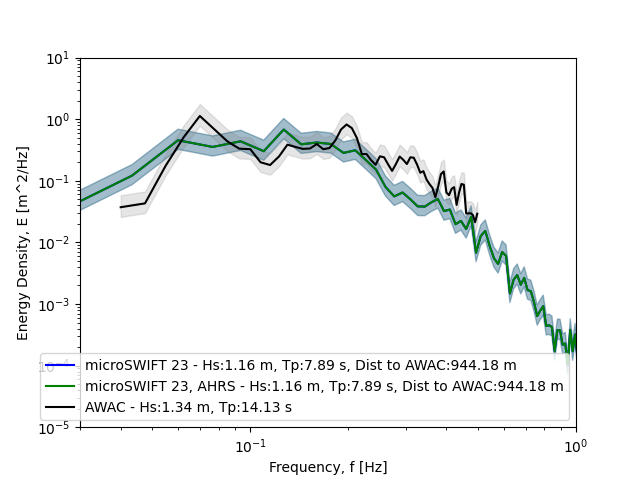

In [18]:
# mission 19, microSWIFT 23 - python function verification
# In python AHRS from MATLAB
nearAWAC_mission19_microSWIFT23 = io.loadmat('./data/nearAWACData_mission19_microSWIFT_23.mat')
mission19_microSWIFT23_accel_z = np.array(accel_z_earth[0])
mission19_microSWIFT23_accel_z_filt, mission19_microSWIFT23_w, mission19_microSWIFT23_z, mission19_microSWIFT23_f, mission19_microSWIFT23_E, mission19_microSWIFT23_dof = processZAccel(mission19_microSWIFT23_accel_z, fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission19_microSWIFT23 = chi2.ppf([1 - alpha / 2, alpha / 2], mission19_microSWIFT23_dof)
c2_mission19_microSWIFT23 = mission19_microSWIFT23_dof / c_mission19_microSWIFT23
mission19_microSWIFT23_Hs, mission19_microSWIFT23_Tp = computeBulkWaveParameters(mission19_microSWIFT23_f, mission19_microSWIFT23_E)
mission19_microSWIFT23_dist2awac = avgDistToAWAC(nearAWAC_mission19_microSWIFT23['x'][0], nearAWAC_mission19_microSWIFT23['y'][0], xFRF_awac, yFRF_awac)
# Computed externally in matlab
nearAWAC_mission19_microSWIFT23_ahrs = io.loadmat('./data/ahrs_mission19_microSWIFT_23.mat')
mission19_microSWIFT23_accel_z_filt_ahrs, mission19_microSWIFT23_w_ahrs, mission19_microSWIFT23_z_ahrs, mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs, mission19_microSWIFT23_dof_ahrs = processZAccel(np.squeeze(nearAWAC_mission19_microSWIFT23_ahrs['az_corrected']), fs, low_freq_cutoff, high_freq_cutoff, filt_order)
c_mission19_microSWIFT23_ahrs = chi2.ppf([1 - alpha / 2, alpha / 2], mission19_microSWIFT23_dof_ahrs)
c2_mission19_microSWIFT23_ahrs = mission19_microSWIFT23_dof_ahrs / c_mission19_microSWIFT23_ahrs
mission19_microSWIFT23_Hs_ahrs, mission19_microSWIFT23_Tp_ahrs = computeBulkWaveParameters(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs)

# Plot the Spectrum from the microSWIFTs and the 4.5 m AWAC
fig_pythonverf, ax1 = plt.subplots()

# microSWIFT 23
ax1.loglog(mission19_microSWIFT23_f, mission19_microSWIFT23_E, color='b', label='microSWIFT 23 - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission19_microSWIFT23_Hs, mission19_microSWIFT23_Tp, mission19_microSWIFT23_dist2awac))
ax1.fill_between(mission19_microSWIFT23_f, mission19_microSWIFT23_E*c2_mission19_microSWIFT23[0], mission19_microSWIFT23_E*c2_mission19_microSWIFT23[1], color='b', alpha=.2)
ax1.loglog(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs, color='g', label='microSWIFT 23, AHRS - Hs:{:.2f} m, Tp:{:.2f} s, Dist to AWAC:{:.2f} m'.format(mission19_microSWIFT23_Hs_ahrs, mission19_microSWIFT23_Tp_ahrs, mission19_microSWIFT23_dist2awac))
ax1.fill_between(mission19_microSWIFT23_f_ahrs, mission19_microSWIFT23_E_ahrs*c2_mission19_microSWIFT23_ahrs[0], mission19_microSWIFT23_E_ahrs*c2_mission19_microSWIFT23_ahrs[1], color='g', alpha=.2)
ax1.loglog(nearAWAC_mission19_microSWIFT23['f_awac'][0], nearAWAC_mission19_microSWIFT23['E_awac'][0], color='k', label='AWAC - Hs:{:.2f} m, Tp:{:.2f} s'.format(nearAWAC_mission19_microSWIFT23['Hs_awac'][0][0], nearAWAC_mission19_microSWIFT23['Tp_awac'][0][0]))
ax1.fill_between(nearAWAC_mission19_microSWIFT23['f_awac'][0], nearAWAC_mission19_microSWIFT23['E_awac'][0]*c2_awac[0], nearAWAC_mission19_microSWIFT23['E_awac'][0]*c2_awac[1], color='gray', alpha=.2)
ax1.set_xlabel('Frequency, f [Hz]')
ax1.set_ylabel('Energy Density, E [m^2/Hz]')
ax1.legend()
ax1.set_xlim(0.03, 1)
ax1.set_ylim(10**-5, 10)

fig_pythonverf.savefig('./figures/pythonVerification.png')

<h3> Phase Comparison between GPS and corrected IMU measurements</h3>